### 2D Viscoelastic Wave Propagation Modeling

In [1]:
"""
==========================================
2D Viscoelastic Wave Propagation Modeling
==========================================

A modular implementation of 2D viscoelastic wave propagation
using finite differences with Kolsky-Futterman attenuation model.

Author: OYEKAN, Hammed Ajiboye
Date: November, 2025
Course: GEOP 603: Numerical Modelling in Geophysics
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from typing import Tuple, Optional, Union
from abc import ABC, abstractmethod
from scipy.fftpack import fft, ifft
from scipy.fft import fft, fftfreq


#### Ricker Wavelet and Its Amplitude Spectrum

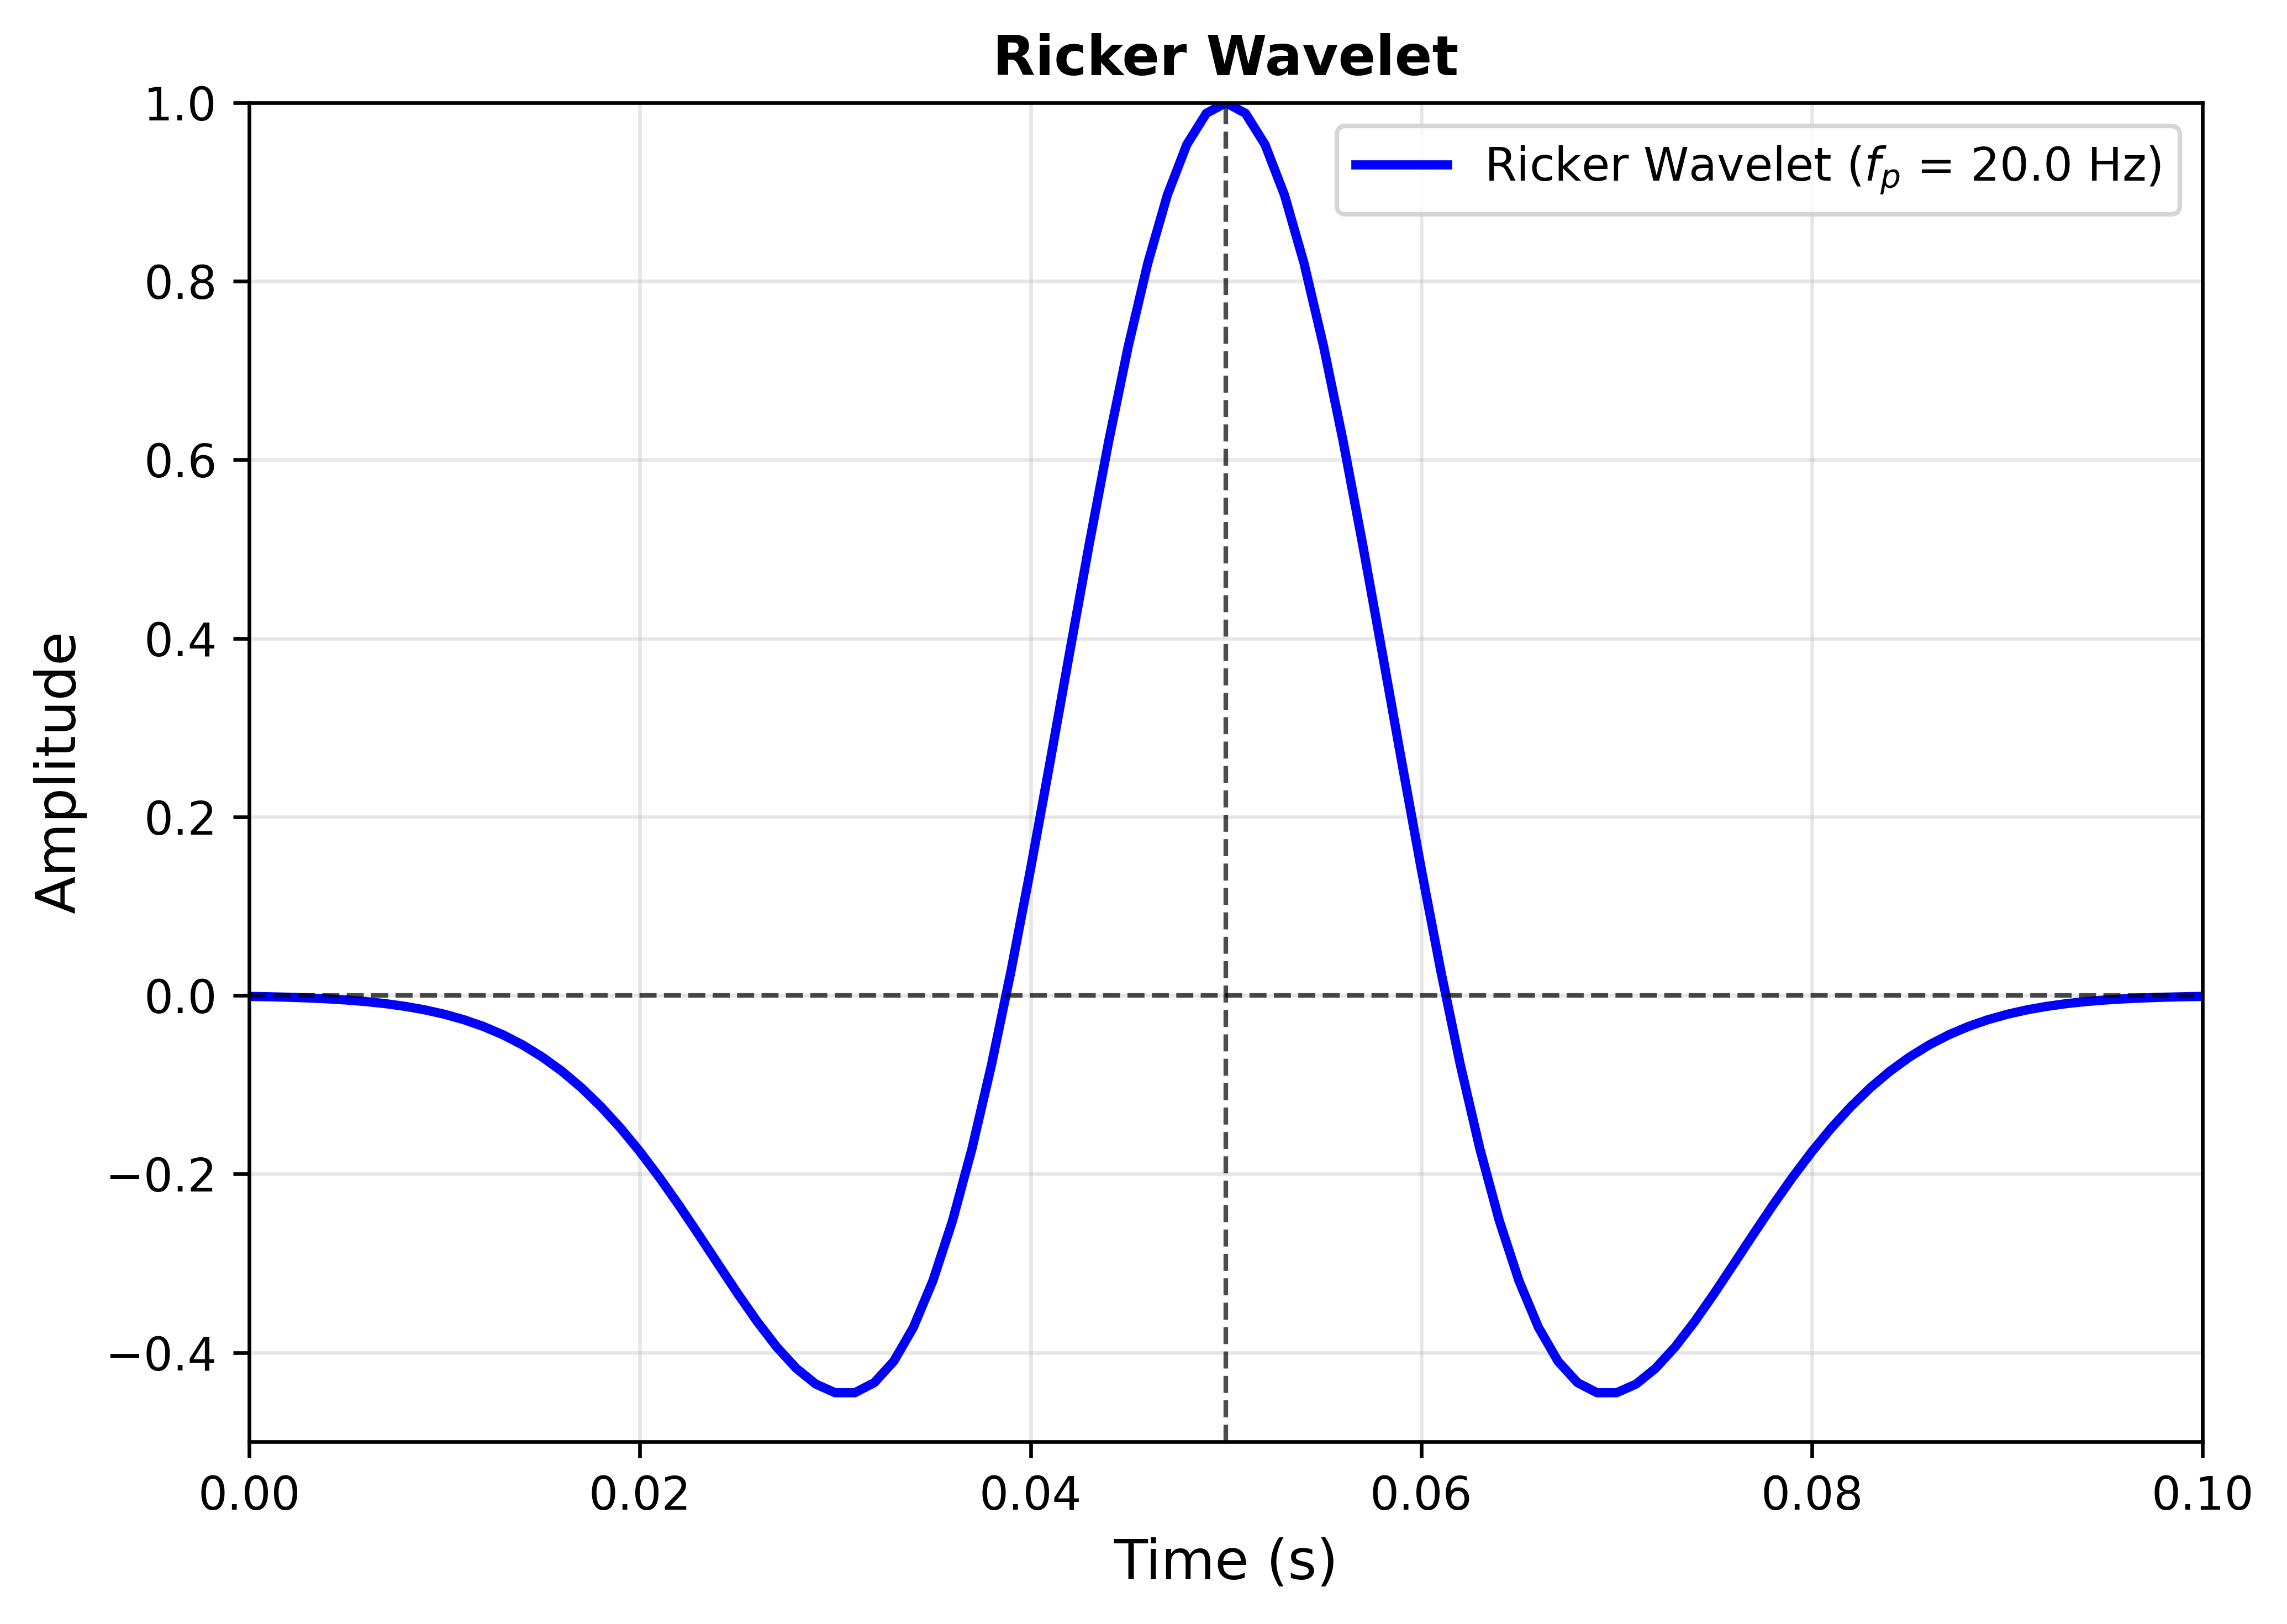

Wavelet parameters:
  Peak frequency:    20.0 Hz
  Time step:         0.001 s
  Number of samples: 1001
  Total duration:    1.000 s
  Maximum amplitude: 1.000
  Time of peak:      0.0500 s


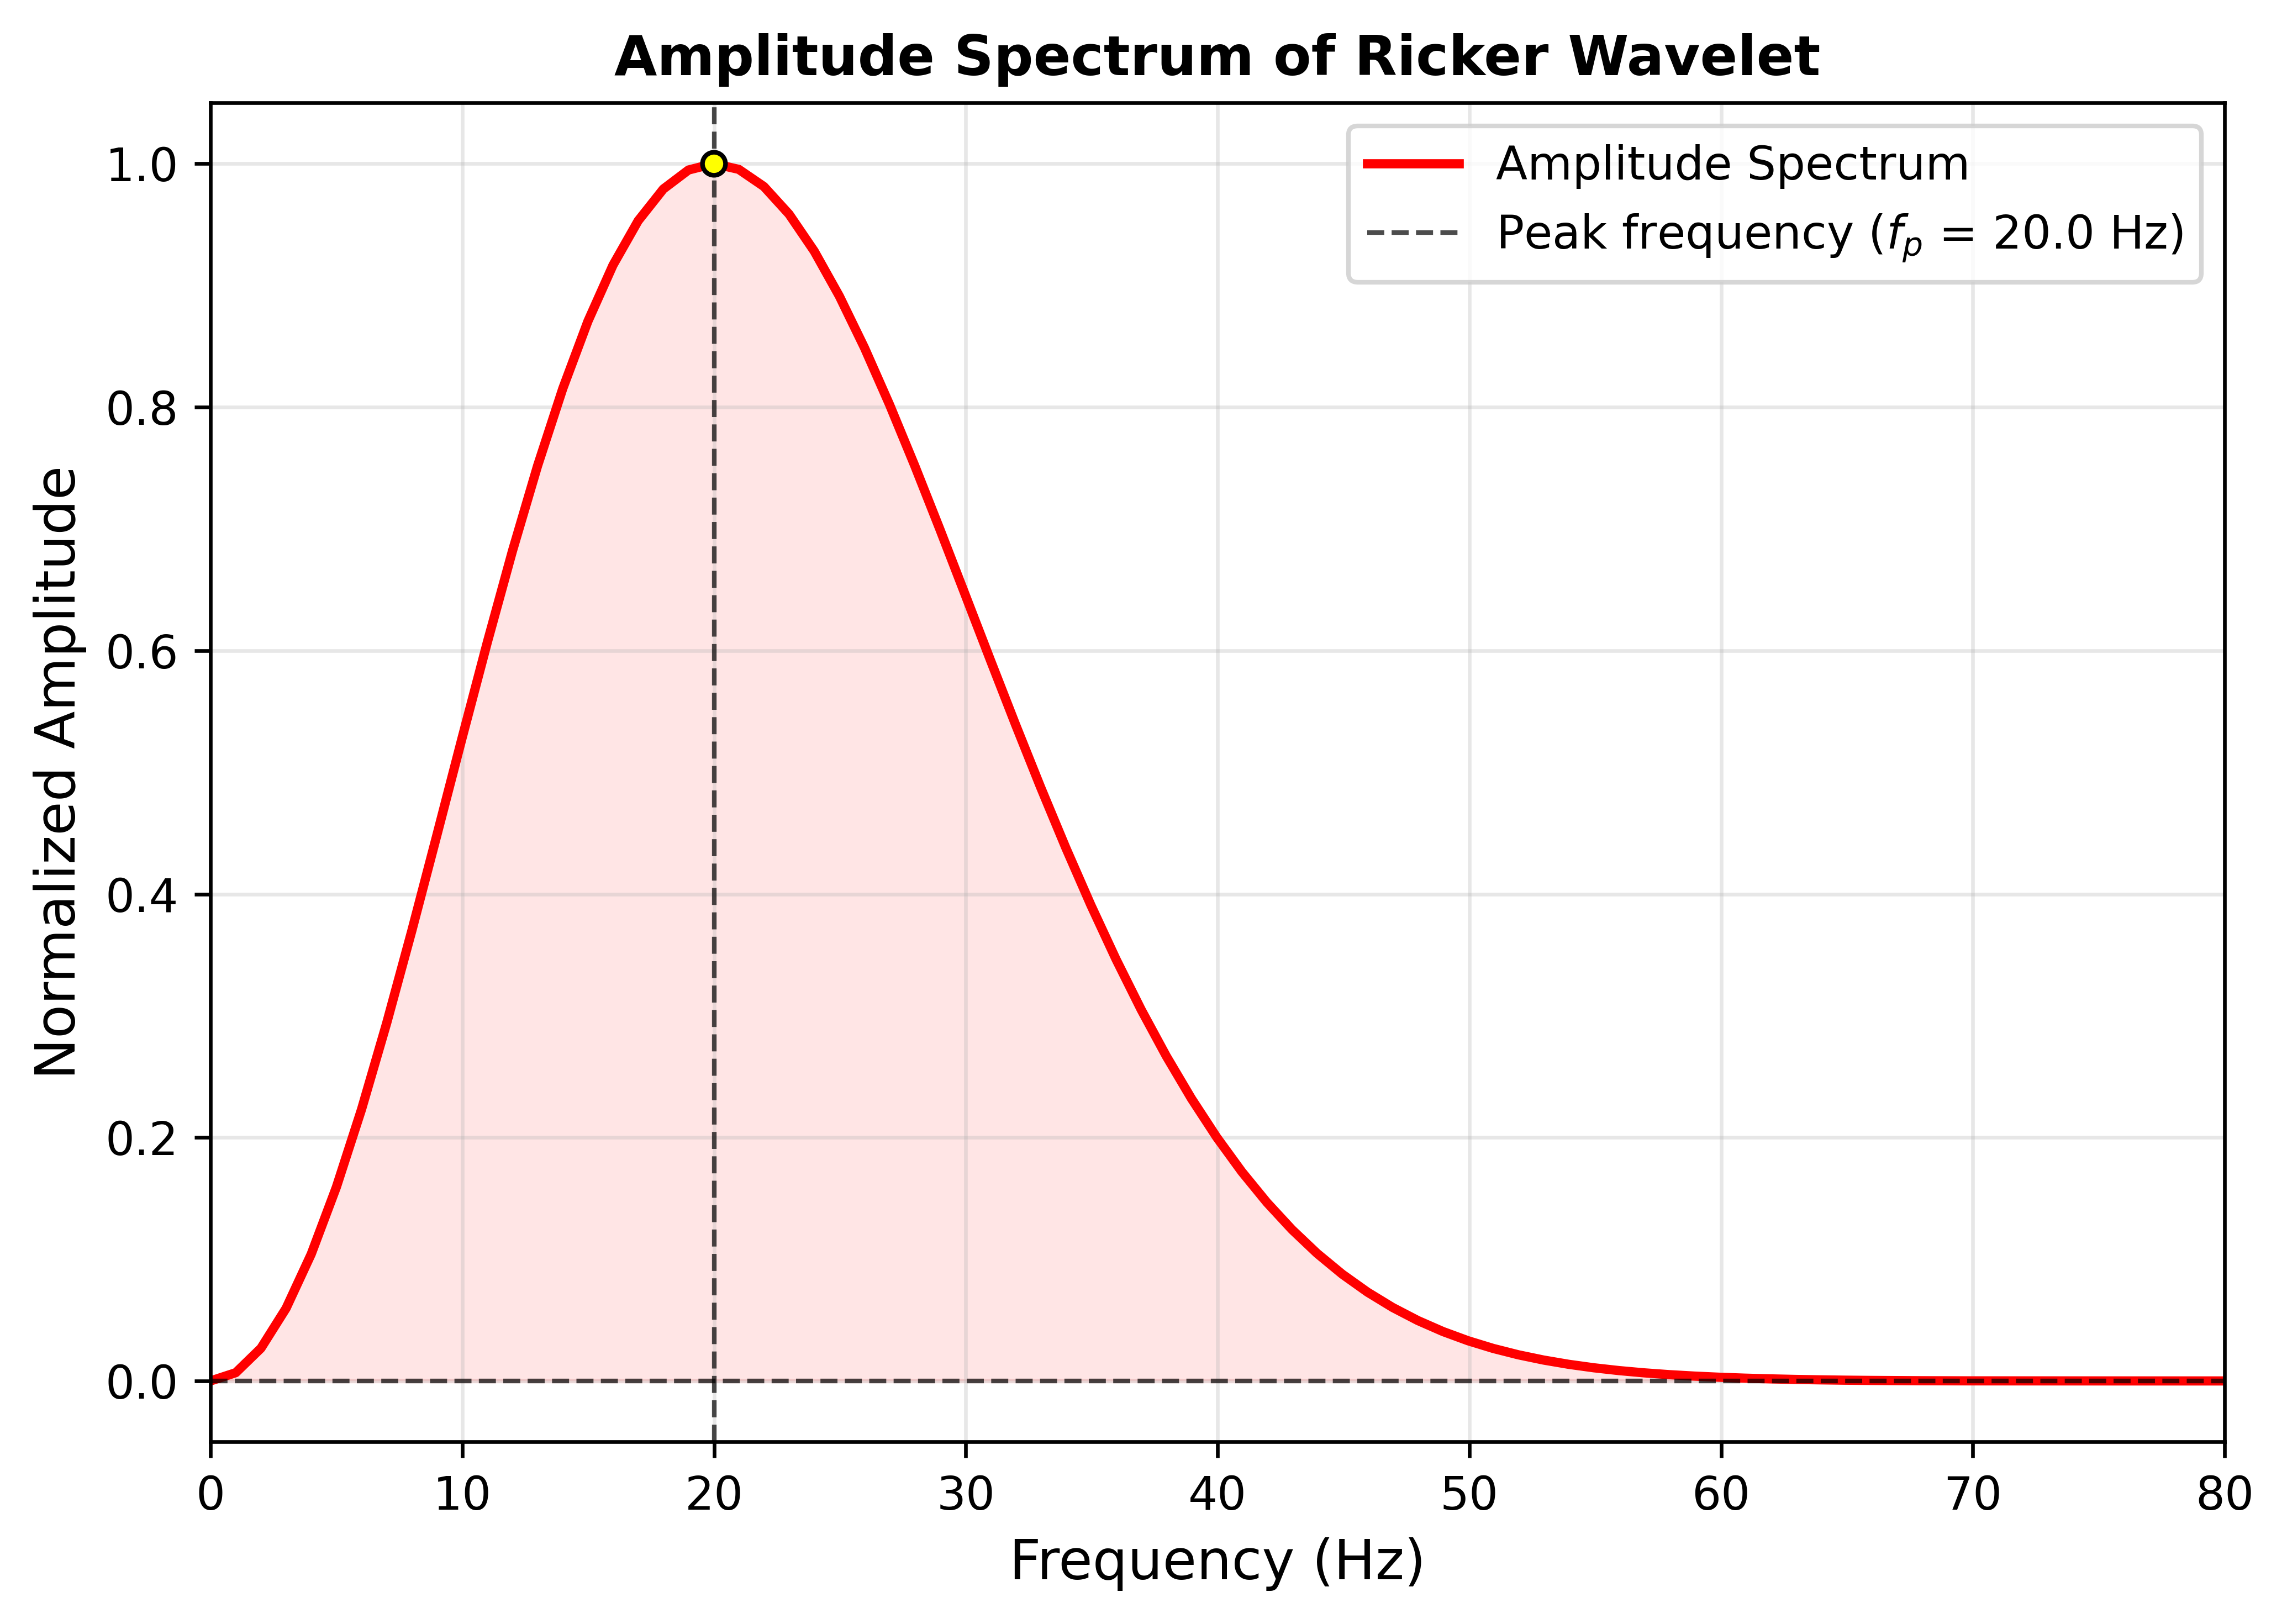


Spectral Analysis:
  Sampling frequency: 1000.0 Hz
  Nyquist frequency:  500.0 Hz
  Frequency resolution: 0.999 Hz
  Amplitude at peak frequency (20.0 Hz): 1.0000
  Approximate -6 dB bandwidth: 22.0 Hz
  Bandwidth range: 10.0 - 32.0 Hz


In [2]:
##########################################
# Function for normalized Ricker wavelet #
##########################################
def ricker(fp, dt, nt):
    """
    Generate a normalized Ricker wavelet.
    
    The Ricker wavelet is a commonly used seismic wavelet that represents
    the second derivative of a Gaussian function. It's characterized by
    its peak frequency and has both positive and negative lobes.
    
    Parameters:
    -----------
    fp (float): Peak frequency of the wavelet (Hz).
                This is the dominant frequency of the wavelet.
    dt (float): Time step/sampling interval (s).
                Must be small enough to properly sample the wavelet.
    nt (int): Number of time samples.
              Determines the length of the generated wavelet.
    
    Returns:
    --------
    numpy.ndarray: Normalized Ricker wavelet with maximum amplitude of 1.
    
    Raises:
    -------
    ValueError: If dt is too large for accurate sampling of the given frequency.
    """
    # Check for numerical stability and accurate sampling
    # The Nyquist criterion suggests dt should be much smaller than the period
    if dt > 1. / (3. * fp):
        raise ValueError("dt > 1 / (3 * fp): Time step too large for the given peak frequency.")
    
    # Calculate the central time (period of the peak frequency)
    # This centers the wavelet in time domain
    t0 = 1. / fp    # Central time (where the wavelet is symmetric)
    
    # Generate the time vector, centered around t0
    # This creates a symmetric time axis with the wavelet peak at the center
    t = np.linspace(0*dt, (nt - 1)*dt, nt)
    
    # Compute the Ricker wavelet using the standard formula:
    # w(t) = (1 - 2π²f²t²) * exp(-π²f²t²)
    # where f is the peak frequency and t is time
    x  = (np.pi * fp * (t-t0)) ** 2     # π²f²t²
    wl = (1. - 2. * x) * np.exp(-x)  # (1 - 2x) * exp(-x) where x = π²f²t²
    
    # Normalize the wavelet to have a maximum amplitude of 1
    # This ensures consistent amplitude regardless of frequency
    wl /= np.max(np.abs(wl))  # Use abs() to handle potential negative peaks
    
    return wl


def plot_amplitude_spectrum(wavelet, dt, fp=None, max_freq=None):
    """
    Plot the amplitude spectrum of a wavelet.
    
    Parameters:
    -----------
    wavelet : numpy.ndarray
        Time-domain wavelet signal
    dt : float
        Time step/sampling interval (s)
    fp : float, optional
        Peak frequency (Hz) for reference line
    max_freq : float, optional
        Maximum frequency to display (Hz). If None, shows up to Nyquist.
    """
    # Calculate sampling frequency
    fs = 1.0 / dt  # Sampling frequency in Hz
    
    # Number of samples
    N = len(wavelet)
    
    # Compute FFT
    wavelet_fft = fft(wavelet)
    
    # Compute frequency vector (positive frequencies only)
    # Since the FFT is symmetric for real signals, we only show the positive frequencies
    freqs = fftfreq(N, dt)[:N//2]
    
    # Compute amplitude spectrum (normalized)
    amplitude = np.abs(wavelet_fft[:N//2]) / N
    
    # Normalize to maximum of 1 for easier interpretation
    amplitude = amplitude / np.max(amplitude)
    
    # Create figure
    plt.figure(figsize=(7, 5), dpi=600)
    
    # Plot amplitude spectrum
    plt.plot(freqs, amplitude, 'r-', linewidth=2, label=f'Amplitude Spectrum')
    plt.fill_between(freqs, amplitude, color='red', alpha=0.1)
    
    # Add peak frequency reference line if provided
    if fp is not None:
        plt.axvline(x=fp, color='k', linestyle='--', alpha=0.7, lw=1., label=f'Peak frequency ($f_p$ = {fp} Hz)')
        
        # Mark the peak on the spectrum
        peak_idx = np.argmin(np.abs(freqs - fp))
        plt.plot(freqs[peak_idx], amplitude[peak_idx], 'ko', markersize=5, markerfacecolor='yellow')
    
    # Set plot labels and title
    plt.title("Amplitude Spectrum of Ricker Wavelet", fontsize=12, fontweight='bold')
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Normalized Amplitude", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Set x-axis limits
    if max_freq is not None:
        plt.xlim(0, max_freq)
    else:
        # Show up to Nyquist frequency by default
        plt.xlim(0, fs/2)
    
    # Set y-axis limits
#     plt.ylim(0, 1.1)
    
    # Add zero line for reference
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.7, lw=1.0)
    
    plt.tight_layout()
    plt.savefig('Amplitude_Spectrum.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print spectral information
    print("\nSpectral Analysis:")
    print(f"  Sampling frequency: {fs:.1f} Hz")
    print(f"  Nyquist frequency:  {fs/2:.1f} Hz")
    print(f"  Frequency resolution: {freqs[1]:.3f} Hz")
    
    if fp is not None:
        peak_idx = np.argmin(np.abs(freqs - fp))
        print(f"  Amplitude at peak frequency ({fp} Hz): {amplitude[peak_idx]:.4f}")
    
    # Find frequency at which amplitude drops to half (bandwidth estimation)
    half_amp_idx = np.where(amplitude >= 0.5)[0]
    if len(half_amp_idx) > 0:
        f_low     = freqs[half_amp_idx[0] ]
        f_high    = freqs[half_amp_idx[-1]]
        bandwidth = f_high - f_low
        print(f"  Approximate -6 dB bandwidth: {bandwidth:.1f} Hz")
        print(f"  Bandwidth range: {f_low:.1f} - {f_high:.1f} Hz")


################################
# Example usage and parameters #
################################
fp = 20.0   # Peak frequency in Hz (25 Hz dominant frequency)
dt = 0.001  # Time step in seconds (1 ms sampling)
nt = 1001   # Number of samples (creates ~1 second of data)
wavelet = ricker(fp, dt, nt)
t       = np.linspace(0*dt, (nt - 1)*dt, nt)   # Time vector in seconds

########################
# Plotting the wavelet #
########################
plt.figure(figsize=(7, 5), dpi=600)  # Set figure size for better visualization
plt.plot(t, wavelet, 'b-', linewidth=2, label=f'Ricker Wavelet ($f_p$ = {fp} Hz)')
plt.title("Ricker Wavelet", fontsize=12, fontweight='bold')
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True, alpha=0.3)  # Add grid for better readability
plt.legend()

# Set reasonable axis limits to focus on the main wavelet
# Adjust these based on your specific needs
plt.xlim(0, 0.1)  # Show ±0.1 seconds around the peak
plt.ylim(-0.5, 1.0)  # Show full amplitude range with some margin

# Add zero line for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.7, lw=1.0)
plt.axvline(x=1/fp, color='k', linestyle='--', alpha=0.7, lw=1.0)

plt.tight_layout()  # Improve spacing
plt.savefig('Ricker_Wavelet.png', dpi=600, bbox_inches='tight')
plt.show()

#############################################################
# Print some useful information about the generated wavelet #
#############################################################
print(f"Wavelet parameters:")
print(f"  Peak frequency:    {fp} Hz")
print(f"  Time step:         {dt} s")
print(f"  Number of samples: {nt}")
print(f"  Total duration:    {dt * (nt - 1):.3f} s")
print(f"  Maximum amplitude: {np.max(np.abs(wavelet)):.3f}")
print(f"  Time of peak:      {t[np.argmax(np.abs(wavelet))]:.4f} s")

############################################
# Plot the amplitude spectrum of wavelet #
############################################
# You can adjust max_freq to zoom in on specific frequency range
plot_amplitude_spectrum(wavelet, dt, fp=fp, max_freq=80)


For the **dissipation** and **viscoelastic** phyiscs, a gaussian filter is applied at specific interval to reduce noise/artifacts that exist during modelling.

Mathematically, the Gaussian function used for the filter kernel is:

In 1D:

$$
G(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{x^2}{2\sigma^2}}
$$

In 2D (used for images):

$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

Where:

* **σ (sigma)** controls the amount of smoothing. TThis is the most important parameter; it determines the width of the bell curve and thus the "strength" of the blur.

  * small σ → little blur
  * large σ → strong blur

### Explicit Forward-Euler viscoelastic solver with Mur ABC.

In [3]:
# ==============================================================================
# DATA CLASSES FOR CONFIGURATION
# ==============================================================================

@dataclass
class GridConfig:
    """Spatial and temporal grid configuration."""
    nz: int           # Number of grid points in z-direction
    nx: int           # Number of grid points in x-direction
    h: float          # Spatial grid spacing (m)
    nt: int           # Number of time steps
    dt: float         # Time step (s)

    @property
    def domain_size_z(self) -> float:
        """Physical domain size in z-direction (m)."""
        return (self.nz - 1) * self.h

    @property
    def domain_size_x(self) -> float:
        """Physical domain size in x-direction (m)."""
        return (self.nx - 1) * self.h

    @property
    def total_time(self) -> float:
        """Total simulation time (s)."""
        return (self.nt - 1) * self.dt

    def validate(self) -> bool:
        """Validate grid parameters."""
        if self.nz <= 0 or self.nx <= 0:
            raise ValueError("Grid dimensions must be positive")
        if self.h <= 0:
            raise ValueError("Grid spacing must be positive")
        if self.nt <= 2:
            raise ValueError("Need at least 3 time steps")
        if self.dt <= 0:
            raise ValueError("Time step must be positive")
        return True


@dataclass
class PhysicsConfig:
    """Physics model configuration."""
    dispersion_enabled: bool = False
    dissipation_enabled: bool = False

    # Kolsky-Futterman parameters
    kf_a: float = 5.7356
    kf_b: float = -762.16
    kf_d: float = 46054.0
        
#     kf_a: float = 4.8317
#     kf_b: float = -309.79
#     kf_d: float = 7769.6

    # This method converts the boolean flags into a list of integers (0 or 1).
    def to_mode_flags(self) -> list:
        """Convert to legacy mode flags format."""
        return [int(self.dispersion_enabled), int(self.dissipation_enabled)]

    def __str__(self) -> str:
        """String representation."""
        return (f"Physics(dispersion={'ON' if self.dispersion_enabled else 'OFF'}, "
                f"dissipation={'ON' if self.dissipation_enabled else 'OFF'})")


@dataclass
class SourceConfig:
    """Source configuration."""
    iz: int           # Source z-index
    ix: int           # Source x-index
    frequency: float  # Dominant frequency (Hz)
    amplitude: float = 1.0

    def get_position(self, h: float) -> Tuple[float, float]:
        """Get physical position in meters."""
        return (self.iz * h, self.ix * h)


@dataclass
class SimulationConfig:
    """Complete simulation configuration."""
    grid: GridConfig
    physics: PhysicsConfig
    source: SourceConfig
    smoothing_sigma: float = 1.0
    smoothing_interval: int = 50
    verbose: bool = True


# ==============================================================================
# VELOCITY MODEL CLASSES
# ==============================================================================

class VelocityModel(ABC):
    """Abstract base class for velocity models."""

    @abstractmethod
    def get_velocity(self, nz: int, nx: int) -> np.ndarray:
        """Get velocity array."""
        pass

    @abstractmethod
    def get_Q(self, nz: int, nx: int) -> np.ndarray:
        """Get quality factor array."""
        pass


class HomogeneousModel(VelocityModel):
    """Homogeneous velocity model."""

    def __init__(self, velocity: float, Q: float):
        self.velocity = velocity
        self.Q_factor = Q

    def get_velocity(self, nz: int, nx: int) -> np.ndarray:
        return self.velocity * np.ones((nz, nx))

    def get_Q(self, nz: int, nx: int) -> np.ndarray:
        return self.Q_factor * np.ones((nz, nx))


class LayeredModel(VelocityModel):
    """Two-layer velocity model."""

    def __init__(self,
                 v_upper: float, v_lower: float,
                 Q_upper: float, Q_lower: float,
                 interface_ratio: float = 1.6):
        """
        Parameters:
        -----------
        v_upper: Upper layer velocity
        v_lower: Lower layer velocity
        Q_upper: Upper layer Q
        Q_lower: Lower layer Q
        interface_ratio: Interface depth = nz / interface_ratio
        """
        self.v_upper = v_upper
        self.v_lower = v_lower
        self.Q_upper = Q_upper
        self.Q_lower = Q_lower
        self.interface_ratio = interface_ratio

    def get_velocity(self, nz: int, nx: int) -> np.ndarray:
        interface_depth = int(nz // self.interface_ratio)
        c0 = self.v_upper * np.ones((nz, nx))
        c0[interface_depth:, :] = self.v_lower
        return c0

    def get_Q(self, nz: int, nx: int) -> np.ndarray:
        interface_depth = int(nz // self.interface_ratio)
        Q = self.Q_upper * np.ones((nz, nx))
        Q[interface_depth:, :] = self.Q_lower
        return Q

# ==============================================================================
# SOURCE WAVELET CLASSES
# ==============================================================================

class SourceWavelet(ABC):
    """Abstract base class for source wavelets."""

    @abstractmethod
    def generate(self, nt: int, dt: float) -> np.ndarray:
        """Generate wavelet time series."""
        pass

class RickerWavelet(SourceWavelet):
    """Ricker (Mexican hat) wavelet."""

    def __init__(self, peak_frequency: float, amplitude: float = 1.0):
        self.fp = peak_frequency
        self.amplitude = amplitude

    def generate(self, nt: int, dt: float) -> np.ndarray:
        """
        Generate a normalized Ricker wavelet.

        The Ricker wavelet is the second derivative of a Gaussian function,
        commonly used in seismic applications.

        Parameters:
        -----------
        nt: Number of time samples
        dt: Time step (s)

        Returns:
        --------
        Normalized Ricker wavelet

        Raises:
        -------
        ValueError: If dt is too large for accurate sampling
        """
        # Check Nyquist criterion
        if dt > 1.0 / (3.0 * self.fp):
            raise ValueError(
                f"dt={dt} too large for fp={self.fp}. "
                f"Requires dt < {1.0/(3.0*self.fp):.6f}"
            )

        # Central time (wavelet peak)
        t0 = 1.0 / self.fp

        # Generate time vector
        t = np.linspace(0, (nt - 1) * dt, nt)

        # Compute Ricker wavelet: (1 - 2x) * exp(-x) where x = (π*f*t)²
        x = (np.pi * self.fp * (t - t0)) ** 2
        wavelet = (1.0 - 2.0 * x) * np.exp(-x)

        # Apply amplitude scaling
        return self.amplitude * wavelet

# ==============================================================================
# BOUNDARY CONDITION CLASSES
# ==============================================================================
class BoundaryCondition(ABC):
    """Abstract base class for boundary conditions."""

    @abstractmethod
    def apply(self, U: np.ndarray, it: int) -> None:
        """Apply boundary condition at time step it."""
        pass


class MurABC(BoundaryCondition):
    """Mur Absorbing Boundary Condition."""

    def __init__(self, c0: np.ndarray, dt: float, h: float):
        """
        Parameters:
        -----------
        c0: Velocity model
        dt: Time step
        h: Spatial grid spacing
        """
        self.dt = dt
        self.h = h
        self._compute_coefficients(c0)

    def _compute_coefficients(self, c0: np.ndarray) -> None:
        """Compute ABC coefficients for each boundary."""
        nz, nx = c0.shape

        # Left boundary
        r_left = c0[1:-1, 0] * self.dt / self.h
        self.c1_left, self.c2_left, self.c3_left, self.c4_left = \
            self._abc_coef(r_left, r_left**2)

        # Right boundary
        r_right = c0[1:-1, -1] * self.dt / self.h
        self.c1_right, self.c2_right, self.c3_right, self.c4_right = \
            self._abc_coef(r_right, r_right**2)

        # Top boundary
        r_top = c0[0, 1:-1] * self.dt / self.h
        self.c1_top, self.c2_top, self.c3_top, self.c4_top = \
            self._abc_coef(r_top, r_top**2)

        # Bottom boundary
        r_bottom = c0[-1, 1:-1] * self.dt / self.h
        self.c1_bottom, self.c2_bottom, self.c3_bottom, self.c4_bottom = \
            self._abc_coef(r_bottom, r_bottom**2)

    @staticmethod
    def _abc_coef(r: Union[float, np.ndarray],
                  r2: Union[float, np.ndarray]) -> Tuple:
        """Compute Mur ABC coefficients."""

        # Input validation for physical consistency
        if np.any(r <= 0):
            raise ValueError("Courant number 'r' must be positive for physical wave propagation")

        if np.any(r > 1.0):
            print("Warning: Courant number r > 1 may cause numerical instability")

        # Verify consistency between r and r2
        if not np.allclose(r**2, r2, rtol=1e-10):
            raise ValueError("Inconsistency detected: r² does not match the provided r2 parameter")

        denom = 1.0 / (r + 1.0)
        c1 = -1.0
        c2 = (r - 1.0) * denom
        c3 = (2.0 - r2) * denom
        c4 = 0.5 * r2 * denom

        return c1, c2, c3, c4

    def apply(self, U: np.ndarray, it: int) -> None:
        """Apply Mur ABC to wavefield U at time step it."""
        boundaries = [
            (slice(1, -1), 0, slice(1, -1), 1,
             self.c1_left, self.c2_left, self.c3_left, self.c4_left, 0),
            (slice(1, -1), -1, slice(1, -1), -2,
             self.c1_right, self.c2_right, self.c3_right, self.c4_right, 1),
            (0, slice(1, -1), 1, slice(1, -1),
             self.c1_top, self.c2_top, self.c3_top, self.c4_top, 2),
            (-1, slice(1, -1), -2, slice(1, -1),
             self.c1_bottom, self.c2_bottom, self.c3_bottom, self.c4_bottom, 3)
        ]

        for bz, bx, nz, nx, c1, c2, c3, c4, idx in boundaries:
            correction = self._compute_correction(U, bz, bx, nz, nx, it, idx)

            U[bz, bx, it + 1] = (
                c1 * U[nz, nx, it - 1] +
                c2 * (U[nz, nx, it + 1] + U[bz, bx, it - 1]) +
                c3 * (U[bz, bx, it] + U[nz, nx, it]) +
                c4 * correction
            )

    @staticmethod
    def _compute_correction(U: np.ndarray, bz, bx, nz, nx, it: int,
                           boundary_idx: int) -> np.ndarray:
        """Compute fourth-order correction term."""
        if boundary_idx == 0:  # Left
            return (U[2:, 1, it] + U[2:, 0, it] +
                   U[:-2, 1, it] + U[:-2, 0, it])
        elif boundary_idx == 1:  # Right
            return (U[2:, -2, it] + U[2:, -1, it] +
                   U[:-2, -2, it] + U[:-2, -1, it])
        elif boundary_idx == 2:  # Top
            return (U[1, 2:, it] + U[0, 2:, it] +
                   U[1, :-2, it] + U[0, :-2, it])
        else:  # Bottom
            return (U[-2, 2:, it] + U[-1, 2:, it] +
                   U[-2, :-2, it] + U[-1, :-2, it])

# ==============================================================================
# MAIN SOLVER CLASS
# ==============================================================================
class ViscoelasticSolver:
    """2D Viscoelastic wave propagation solver."""

    def __init__(self, config: SimulationConfig, model: VelocityModel):
        """
        Parameters:
        -----------
        config: Simulation configuration
        model: Velocity model
        """
        self.config = config
        self.model  = model

        # Validate configuration
        config.grid.validate()

        # Initialize model
        self.c0 = model.get_velocity(config.grid.nz, config.grid.nx)
        self.Q  = model.get_Q(config.grid.nz, config.grid.nx)

        # Initialize wavefields
        self._initialize_wavefields()

        # Compute coefficients
        self._compute_coefficients()

        # Initialize boundary conditions
        self.abc = MurABC(self.c0, config.grid.dt, config.grid.h)

        # Generate source wavelet
        self._generate_source()

        if config.verbose:
            self._print_info()

    def _initialize_wavefields(self) -> None:
        """Initialize displacement wavefields."""
        shape    = (self.config.grid.nz, self.config.grid.nx, self.config.grid.nt)
        self.U_z = np.zeros(shape, dtype=np.complex64)
        self.U_x = np.zeros(shape, dtype=np.complex64)

        # Workspace for Laplacian
        self.lap_z = np.zeros((self.config.grid.nz, self.config.grid.nx), dtype=np.complex64)
        self.lap_x = np.zeros((self.config.grid.nz, self.config.grid.nx), dtype=np.complex64)

    def _compute_coefficients(self) -> None:
        """Compute viscoelastic coefficients."""
        cfg = self.config

        # Get KF parameters
        if cfg.physics.dispersion_enabled:
            a, b, d = cfg.physics.kf_a, cfg.physics.kf_b, cfg.physics.kf_d
        else:
            a, b, d = 0.0, 0.0, 0.0

        e = 1.0 if cfg.physics.dissipation_enabled else 0.0

        # Compute complex coefficients
        dt = cfg.grid.dt
        impedance = 1.0 - 2.0*a/(np.pi*self.Q) - e*1j/self.Q - \
                   b*1j/(np.pi*self.Q)*dt

        self.C1 = 1.0 / impedance
        self.C2 = 2.0 * (1.0 - 2.0*a/(np.pi*self.Q) - e*1j/self.Q -
                        d/(np.pi*self.Q)*dt*dt)
        self.C3 = -(1.0 - 2.0*a/(np.pi*self.Q) - e*1j/self.Q +
                   b*1j/(np.pi*self.Q)*dt)

        # Compute Courant numbers
        self.r = self.c0 * cfg.grid.dt / cfg.grid.h
        self.r2 = self.r ** 2

        # Check stability
        if np.any(self.r > 1.0):
            print("⚠️ WARNING: CFL condition violated!")

    def _generate_source(self) -> None:
        """Generate source wavelet."""
        wavelet_gen = RickerWavelet(
            self.config.source.frequency,
            self.config.source.amplitude
        )
        wavelet = wavelet_gen.generate(
            self.config.grid.nt,
            self.config.grid.dt
        )
        
        self.wave   = wavelet     # Real Signal
        self.source = hilbert(wavelet) # Analytical

    def _print_info(self) -> None:
        """Print simulation information."""
        cfg = self.config
        print("=" * 150)
        print("2D VISCOELASTIC WAVE PROPAGATION SOLVER - Explicit Forward Euler with Mur ABC Implementation")
        print("=" * 150)
        print(f"\nGrid: {cfg.grid.nz} × {cfg.grid.nx}, spacing: {cfg.grid.h} m")
        print(f"Domain: {cfg.grid.domain_size_z:.0f} × {cfg.grid.domain_size_x:.0f} m")
        print(f"Time: {cfg.grid.nt} steps, dt: {cfg.grid.dt} s, "
              f"total: {cfg.grid.total_time:.3f} s")
        print(f"\nVelocity: {np.min(self.c0):.0f} - {np.max(self.c0):.0f} m/s")
        print(f"Q-factor: {np.min(self.Q):.0f} - {np.max(self.Q):.0f}")
        print(f"\nSource: {cfg.source.frequency} Hz at "
              f"({cfg.source.iz*cfg.grid.h:.0f}, {cfg.source.ix*cfg.grid.h:.0f}) m")
        print(f"\n{cfg.physics}")
        print("=" * 80)

    def run(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Run the simulation.

        Returns:
        --------
        U_z, U_x: Vertical and horizontal displacement fields
        """
        cfg = self.config
        src_iz, src_ix = cfg.source.iz, cfg.source.ix

        ismth_start = max(1, int(np.ceil(2.0 / (cfg.source.frequency * cfg.grid.dt))))

        print("\nStarting time-stepping...")

        for it in range(1, cfg.grid.nt - 1):
            # Progress monitoring
            if cfg.verbose and it % 100 == 0:
                # Compute amplitude statistics
                max_uz = np.max(np.abs(self.U_z[:, :, it]))
                max_ux = np.max(np.abs(self.U_x[:, :, it]))
                min_uz = np.min(np.abs(self.U_z[:, :, it]))
                min_ux = np.min(np.abs(self.U_x[:, :, it]))

                print(f"Step {it:4d}/{cfg.grid.nt-2}: "
                      f"|U_z|_max = {max_uz:.2e}, |U_x|_max = {max_ux:.2e}, |U_z|_min = {min_uz:.2e}, |U_x|_min = {min_ux:.2e}")

            # Source injection
            self.U_z[src_iz, src_ix, it] += self.source[it]    #Analytical Signal
            # self.U_z[src_iz, src_ix, it] += self.wave[it]    #Real Signal

            # Compute spatial derivatives
            self._compute_spatial_derivatives(it)

            # Time stepping
            self.U_z[:, :, it + 1] = self.C1 * (
                self.C2 * self.U_z[:, :, it] +
                self.C3 * self.U_z[:, :, it - 1] +
                self.r2 * self.lap_z
            )
            self.U_x[:, :, it + 1] = self.C1 * (
                self.C2 * self.U_x[:, :, it] +
                self.C3 * self.U_x[:, :, it - 1] +
                self.r2 * self.lap_x
            )

            # Apply smoothing if needed
#             if (cfg.physics.dissipation_enabled and it >= ismth_start and
#                 it % cfg.smoothing_interval == 0):
#                 self._apply_smoothing(it)

            # Apply boundary conditions
            self.abc.apply(self.U_z, it)
            self.abc.apply(self.U_x, it)

        print("✓ Simulation completed successfully!")
        return self.U_z, self.U_x

    def _compute_spatial_derivatives(self, it: int) -> None:
        """Compute spatial derivatives (Laplacian with coupling)."""
        Uz = self.U_z[:, :, it]
        Ux = self.U_x[:, :, it]

        # Vertical displacement derivatives
        self.lap_z[1:-1, 1:-1] = (1.0 / 3.0) * (
            3.0 * (Uz[2:, 1:-1] - 2.0*Uz[1:-1, 1:-1] + Uz[:-2, 1:-1]) +
            2.0 * (Ux[2:, 2:] - Ux[:-2, 2:] - Ux[2:, :-2] + Ux[:-2, :-2]) / 4.0 +
            (Uz[1:-1, 2:] - 2.0*Uz[1:-1, 1:-1] + Uz[1:-1, :-2])
        )

        # Horizontal displacement derivatives
        self.lap_x[1:-1, 1:-1] = (1.0 / 3.0) * (
            3.0 * (Ux[1:-1, 2:] - 2.0*Ux[1:-1, 1:-1] + Ux[1:-1, :-2]) +
            2.0 * (Uz[2:, 2:] - Uz[:-2, 2:] - Uz[2:, :-2] + Uz[:-2, :-2]) / 4.0 +
            (Ux[2:, 1:-1] - 2.0*Ux[1:-1, 1:-1] + Ux[:-2, 1:-1])
        )

    def _apply_smoothing(self, it: int) -> None:
        """Apply Gaussian smoothing."""
        sigma = self.config.smoothing_sigma

        for U_field in [self.U_z, self.U_x]:
            U_field[:, :, it] = (
                gaussian_filter(np.real(U_field[:, :, it]), sigma) +
                1j * gaussian_filter(np.imag(U_field[:, :, it]), sigma)
            )
            U_field[:, :, it + 1] = (
                gaussian_filter(np.real(U_field[:, :, it + 1]), sigma) +
                1j * gaussian_filter(np.imag(U_field[:, :, it + 1]), sigma)
            )

# ==============================================================================
# VISUALIZATION CLASS
# ==============================================================================

class WavefieldVisualizer:
    """Visualizer for wavefield simulation results."""

    def __init__(self, results: dict, grid: GridConfig):
        """
        Parameters:
        -----------
        results: Dictionary containing simulation results
        grid: Grid configuration
        """
        self.results = results
        self.grid    = grid

        self.mode_titles = {
            'elastic': 'Pure Elastic\n(No dispersion, No dissipation)',
            'dissipative': 'Dissipative Only\n(Energy absorption)',
            'dispersive': 'Dispersive Only\n(Frequency-dependent velocity)',
            'viscoelastic': 'Full Viscoelastic\n(Dispersion + Dissipation)'
        }

        self.colors = ['black', 'red', 'blue', 'green']

    def plot_snapshots(self, time_step: int, clip: float = 0.1,
                      interface_ratio: float = 1.6, save: bool = True):
        """
        Create snapshot comparisons for all physics modes.

        Parameters:
        -----------
        time_step: Time step to visualize
        clip: Amplitude clipping for display
        interface_ratio: Interface depth ratio (depth = nz / ratio)
        save: Whether to save figures
        """
        time_vis = time_step * self.grid.dt
        interface_depth = int(self.grid.nz // interface_ratio) * self.grid.h

        mode_keys = ['elastic', 'dissipative', 'dispersive', 'viscoelastic']

        # Plot 1: Vertical displacement
        self._plot_displacement_comparison(
            mode_keys, time_step, time_vis, clip, interface_depth,
            component='U_z', title='Vertical Displacement ($U_z$)',
            filename='viscoelastic_uz_comparison.png' if save else None
        )

        # Plot 2: Horizontal displacement
        self._plot_displacement_comparison(
            mode_keys, time_step, time_vis, clip, interface_depth,
            component='U_x', title='Horizontal Displacement ($U_x$)',
            filename='viscoelastic_ux_comparison.png' if save else None
        )

        # Plot 3: Total displacement magnitude
        self._plot_total_displacement(
            mode_keys, time_step, time_vis, clip, interface_depth,
            filename='viscoelastic_total_displacement.png' if save else None
        )

    def _plot_displacement_comparison(self, mode_keys, time_step, time_vis,
                                     clip, interface_depth, component='U_z',
                                     title='', filename=None):
        """Plot displacement comparison for all modes."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{title} at t = {time_vis:.3f} s', fontsize=16, fontweight='bold')

        for idx, mode_key in enumerate(mode_keys):
            row, col = idx // 2, idx % 2
            ax       = axes[row, col]

            # Extract displacement component
            if component == 'U_z':
                U = self.results[mode_key]['U_z']
            else:
                U = self.results[mode_key]['U_x']

            U_real = np.real(U[:, :, time_step])

            # Create image plot
            im = ax.imshow(U_real,
                          vmin=-clip, vmax=clip,
                          cmap='seismic',
                          aspect='equal',
                          extent=[0, self.grid.domain_size_x, self.grid.domain_size_z, 0],
                          origin='upper')

            # Formatting
            ax.set_title(self.mode_titles[mode_key], fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Distance (m)', fontsize=10)
            ax.set_ylabel('Depth (m)', fontsize=10)

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=1.0, pad=0.02)
            cbar.set_label('Amplitude', rotation=270, labelpad=15, fontsize=9)
            cbar.ax.tick_params(labelsize=8)

            # Mark source location (assuming centered)
            src_z = (self.grid.nz // 2) * self.grid.h
            src_x = (self.grid.nx // 2) * self.grid.h
            ax.plot(src_x, src_z, 'w*', markersize=12,
                   markeredgecolor='black', markeredgewidth=1)

            # Show velocity interface
            ax.axhline(y=interface_depth, color='black', linestyle='--',
                      alpha=0.7, linewidth=1.0,
                      label=f'Interface ({interface_depth:.0f}m)')

            # Add grid
            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, color='gray')
            ax.tick_params(labelsize=8)

            # Add amplitude statistics
            max_amp = np.max(np.abs(U_real))
            ax.text(0.02, 0.98, f'Max: {max_amp:.3f}', transform=ax.transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=600, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
            print(f"Saved: {filename}")
        plt.show()

    def _plot_total_displacement(self, mode_keys, time_step, time_vis,
                                clip, interface_depth, filename=None):
        """Plot total displacement magnitude comparison."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Total Displacement Magnitude at t = {time_vis:.3f} s',
                    fontsize=16, fontweight='bold')

        for idx, mode_key in enumerate(mode_keys):
            row, col = idx // 2, idx % 2
            ax       = axes[row, col]

            # Compute total displacement
            U_z_real = np.real(self.results[mode_key]['U_z'][:, :, time_step])
            U_x_real = np.real(self.results[mode_key]['U_x'][:, :, time_step])
            U_total  = np.sqrt(U_z_real**2 + U_x_real**2)

            # Create image plot
            im = ax.imshow(U_total,
                          vmin=0, vmax=clip,
                          cmap='hot',
                          aspect='equal',
                          extent=[0, self.grid.domain_size_x,
                                 self.grid.domain_size_z, 0],
                          origin='upper')

            # Formatting
            ax.set_title(self.mode_titles[mode_key], fontsize=12,
                        fontweight='bold', pad=10)
            ax.set_xlabel('Distance (m)', fontsize=10)
            ax.set_ylabel('Depth (m)', fontsize=10)

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=1.0, pad=0.02)
            cbar.set_label('|U| Magnitude', rotation=270, labelpad=15, fontsize=9)
            cbar.ax.tick_params(labelsize=8)

            # Mark source and interface
            src_z = (self.grid.nz // 2) * self.grid.h
            src_x = (self.grid.nx // 2) * self.grid.h
            ax.plot(src_x, src_z, 'w*', markersize=12,
                   markeredgecolor='black', markeredgewidth=1)
            ax.axhline(y=interface_depth, color='white', linestyle='--',
                      alpha=0.7, linewidth=1.0)

            # Add grid and statistics
            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, color='gray')
            ax.tick_params(labelsize=8)

            max_total = np.max(U_total)
            ax.text(0.02, 0.98, f'Max: {max_total:.3f}', transform=ax.transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=600, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
            print(f"Saved: {filename}")
        plt.show()

    def plot_seismograms(self, receiver_positions: list = None,
                        mode_keys: list = None,
                        time_range: tuple = None,
                        horizontal_trace_depth: int = None,
                        vertical_trace_x: int = None,
                        snapshot_idx: int = 1000,
                        save: bool = True):
        """
        Plot seismograms and spatial traces.

        Parameters:
        -----------
        receiver_positions: List of (iz, ix, label) tuples for receivers
        mode_keys: List of physics modes to plot
        time_range: (t_min, t_max) for seismogram display
        horizontal_trace_depth: Depth index for horizontal trace
        vertical_trace_x: X index for vertical trace
        snapshot_idx: Time index for spatial traces
        save: Whether to save figure
        """
        if mode_keys is None:
            mode_keys = ['elastic', 'viscoelastic']

        if receiver_positions is None:
            receiver_positions = [
                (self.grid.nz // 4, self.grid.nx // 2, "Shallow"),
                (3 * self.grid.nz // 4, self.grid.nx // 2, "Deep")
            ]

        if horizontal_trace_depth is None:
            horizontal_trace_depth = int(2100 / self.grid.h)

        if vertical_trace_x is None:
            vertical_trace_x = int(1500 / self.grid.h)

        fig, axes = plt.subplots(4, 1, figsize=(16, 14))
        fig.suptitle('Seismogram and Spatial Trace Comparison',
                    fontsize=14, fontweight='bold')

        time_axis = np.arange(self.grid.nt) * self.grid.dt

        #############################
        # Plot receiver seismograms #
        #############################
        for i, (iz, ix, location) in enumerate(receiver_positions):
            ax = axes[i]

            for j, mode_key in enumerate(mode_keys):
                U_z = self.results[mode_key]['U_z']
                seismogram = np.real(U_z[iz, ix, :])

                ax.plot(time_axis, seismogram,
                       color=self.colors[j], linewidth=1.5,
                       label=self.mode_titles[mode_key].split('\n')[0])

            ax.set_title(f'{location} Receiver at '
                        f'({iz*self.grid.h:.0f}, {ix*self.grid.h:.0f}) m',
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Time (s)', fontsize=10)
            ax.set_ylabel('$U_z$ Amplitude', fontsize=10)

            if time_range:
                ax.set_xlim(time_range)
            else:
                ax.set_xlim(0.25, 0.7)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9, loc='best')
            ax.tick_params(labelsize=8)

        ###############################
        # Third row: Horizontal trace #
        ###############################
        ax_horizontal = axes[2]
        distance_km   = np.arange(self.grid.nx) * self.grid.h / 1000.0

        for j, mode_key in enumerate(mode_keys):
            U_z = self.results[mode_key]['U_z']
            amplitude_profile = np.real(U_z[horizontal_trace_depth, :, snapshot_idx])
            ax_horizontal.plot(distance_km, amplitude_profile,
                             color=self.colors[j], linewidth=1.5,
                             label=self.mode_titles[mode_key].split('\n')[0])

        ax_horizontal.set_xlabel('Distance (km)', fontsize=10)
        ax_horizontal.set_ylabel('$U_z$ Amplitude', fontsize=10)
        ax_horizontal.set_title(
            f'Horizontal Trace at depth = {horizontal_trace_depth*self.grid.h:.0f} m, '
            f't = {snapshot_idx*self.grid.dt:.3f} s',
            fontsize=11, fontweight='bold')
        ax_horizontal.set_xlim(0., distance_km[-1])
        ax_horizontal.grid(True, alpha=0.3)
        ax_horizontal.legend(fontsize=8, loc='best')
        ax_horizontal.axhline(y=0, color='gray', linestyle='--',
                             linewidth=1.0, alpha=0.7)

        ################################################################################
        # Fourth subplot: Distance vs Amplitude at specific time step - Vertical trace #
        ################################################################################
        ax_vertical = axes[3]
        distance_km = np.arange(self.grid.nz) * self.grid.h / 1000.0

        for j, mode_key in enumerate(mode_keys):
            U_z = self.results[mode_key]['U_z']
            amplitude_profile = np.real(U_z[:, vertical_trace_x, snapshot_idx])
            ax_vertical.plot(distance_km, amplitude_profile,
                           color=self.colors[j], linewidth=1.5,
                           label=self.mode_titles[mode_key].split('\n')[0])

        ax_vertical.set_xlabel('Distance (km)', fontsize=10)
        ax_vertical.set_ylabel('$U_z$ Amplitude', fontsize=10)
        ax_vertical.set_title(
            f'Vertical Trace at x = {vertical_trace_x*self.grid.h:.0f} m, '
            f't = {snapshot_idx*self.grid.dt:.3f} s',
            fontsize=11, fontweight='bold')
        ax_vertical.set_xlim(0., distance_km[-1])
        ax_vertical.grid(True, alpha=0.3)
        ax_vertical.legend(fontsize=8, loc='best')
        ax_vertical.axhline(y=0, color='gray', linestyle='--',
                           linewidth=1.0, alpha=0.7)

        plt.tight_layout()
        if save:
            plt.savefig('viscoelastic_seismograms.png', dpi=600,
                       bbox_inches='tight', facecolor='white', edgecolor='none')
            print("Saved: viscoelastic_seismograms.png")
        plt.show()

    def print_summary(self, mode_keys: list = None):
        """Print simulation summary."""
        if mode_keys is None:
            mode_keys = ['elastic', 'viscoelastic']

        print("\n" + "=" * 80)
        print("SIMULATION ANALYSIS SUMMARY")
        print("=" * 80)

        print(f"\nSimulation Parameters:")
        print(f"  Grid: {self.grid.nz} × {self.grid.nx} points, "
              f"spacing: {self.grid.h} m")
        print(f"  Time: {self.grid.nt} steps, dt: {self.grid.dt} s, "
              f"total: {self.grid.total_time:.3f} s")

        print(f"\nPhysics Effects:")
        for mode_key in mode_keys:
            U_z = self.results[mode_key]['U_z']
            U_x = self.results[mode_key]['U_x']
            max_uz = np.max(np.abs(U_z))
            max_ux = np.max(np.abs(U_x))
            energy_ratio = max_ux / max_uz if max_uz > 0 else 0

            print(f"  {self.mode_titles[mode_key].split()[0]:>12}: "
                  f"max |U_z| = {max_uz:.4e}, max |U_x| = {max_ux:.4e}, "
                  f"U_x/U_z = {energy_ratio:.3f}")

        print(f"\nKey Observations:")
        print(f"  • Elastic: Pure wave propagation without attenuation")
        print(f"  • Dissipative: Energy absorption reduces amplitudes")
        print(f"  • Dispersive: Frequency-dependent velocity causes pulse broadening")
        print(f"  • Viscoelastic: Combined effects show realistic wave behavior")

        print(f"\nOutput Files Generated:")
        print(f"  • viscoelastic_uz_comparison.png")
        print(f"  • viscoelastic_ux_comparison.png")
        print(f"  • viscoelastic_total_displacement.png")
        print(f"  • viscoelastic_seismograms.png")

        print("\n" + "=" * 80)

# ==============================================================================
# EXAMPLE USAGE
# ==============================================================================

def run_all_simulations(grid: GridConfig, model: VelocityModel,
                        source: SourceConfig, verbose: bool = True):
    """
    Run all 4 physics simulations and return results.

    Parameters:
    -----------
    grid: Grid configuration
    model: Velocity model
    source: Source configuration
    verbose: Print progress information

    Returns:
    --------
    dict: Results dictionary with structure:
        {
            'elastic': {'U_z': ..., 'U_x': ..., 'solver': ...},
            'dissipative': {...},
            'dispersive': {...},
            'viscoelastic': {...}
        }
    """
    # Define all physics modes
    physics_modes = {
        'elastic': PhysicsConfig(dispersion_enabled=False, dissipation_enabled=False),
        'dissipative': PhysicsConfig(dispersion_enabled=False, dissipation_enabled=True),
        'dispersive': PhysicsConfig(dispersion_enabled=True, dissipation_enabled=False),
        'viscoelastic': PhysicsConfig(dispersion_enabled=True, dissipation_enabled=True)
    }

    results = {}

    # Run all simulations
    for mode_name, physics in physics_modes.items():
        if verbose:
            print(f"\n{'='*60}")
            print(f"Running {mode_name.upper()} simulation")
            print(f"{'='*60}")

        config   = SimulationConfig(grid, physics, source, verbose=verbose)
        solver   = ViscoelasticSolver(config, model)
        U_z, U_x = solver.run()

        results[mode_name] = {
            'U_z': U_z,
            'U_x': U_x,
            'solver': solver
        }

        if verbose:
            max_uz = np.max(np.abs(U_z))
            max_ux = np.max(np.abs(U_x))
            print(f"Final amplitudes: |U_z|_max = {max_uz:.4e}, "
                  f"|U_x|_max = {max_ux:.4e}")

    if verbose:
        print("\n" + "="*80)
        print("✓ All 4 physics simulations completed successfully!")
        print("="*80)

    return results


####  Setup and Run the Full Simulation

In [4]:
# # Configure simulation
# grid = GridConfig(
#     nz=751, nx=751, h=4.0,
#     nt=2001, dt=0.0005 )

grid = GridConfig(
    nz=201, nx=201, h=5.0,
    nt=1001, dt=0.001)

source = SourceConfig(
    iz=grid.nz // 2,
    ix=grid.nx // 2,
    frequency=20.0 )

model = LayeredModel(
    v_upper=1800, v_lower=3000,
    Q_upper=30, Q_lower=100,
    interface_ratio=1.6 )

import time

start_time = time.time()

# Run simulations
results = run_all_simulations(grid, model, source)

elapsed = time.time() - start_time

# Format nicely
hours   = int(elapsed // 3600)
minutes = int((elapsed % 3600) // 60)
seconds = elapsed % 60

print(f"\nTotal simulation time: {hours}h {minutes}m {seconds:.2f}s")



Running ELASTIC simulation
2D VISCOELASTIC WAVE PROPAGATION SOLVER - Implicit Backward Euler with Sponge Layer ABC Implementation

Grid: 201 × 201, spacing: 5.0 m
Domain: 1000 × 1000 m
Time: 1001 steps, dt: 0.001 s, total: 1.000 s

Velocity: 1800 - 3000 m/s
Q-factor: 30 - 100

Source: 20.0 Hz at (500, 500) m

Physics(dispersion=OFF, dissipation=OFF)

Starting time-stepping...
Step  100/999: |U_z|_max = 1.67e+00, |U_x|_max = 1.07e+00, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  200/999: |U_z|_max = 1.02e+00, |U_x|_max = 7.65e-01, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  300/999: |U_z|_max = 1.36e+00, |U_x|_max = 5.57e-01, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  400/999: |U_z|_max = 1.23e+00, |U_x|_max = 4.12e-01, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  500/999: |U_z|_max = 1.08e+00, |U_x|_max = 4.01e-01, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  600/999: |U_z|_max = 7.86e-01, |U_x|_max = 5.42e-01, |U_z|_min = 0.00e+00, |U_x|_min = 0.00e+00
Step  70

#### Visualize - Snapshots


Generating snapshot comparisons...
Saved: viscoelastic_uz_comparison.png


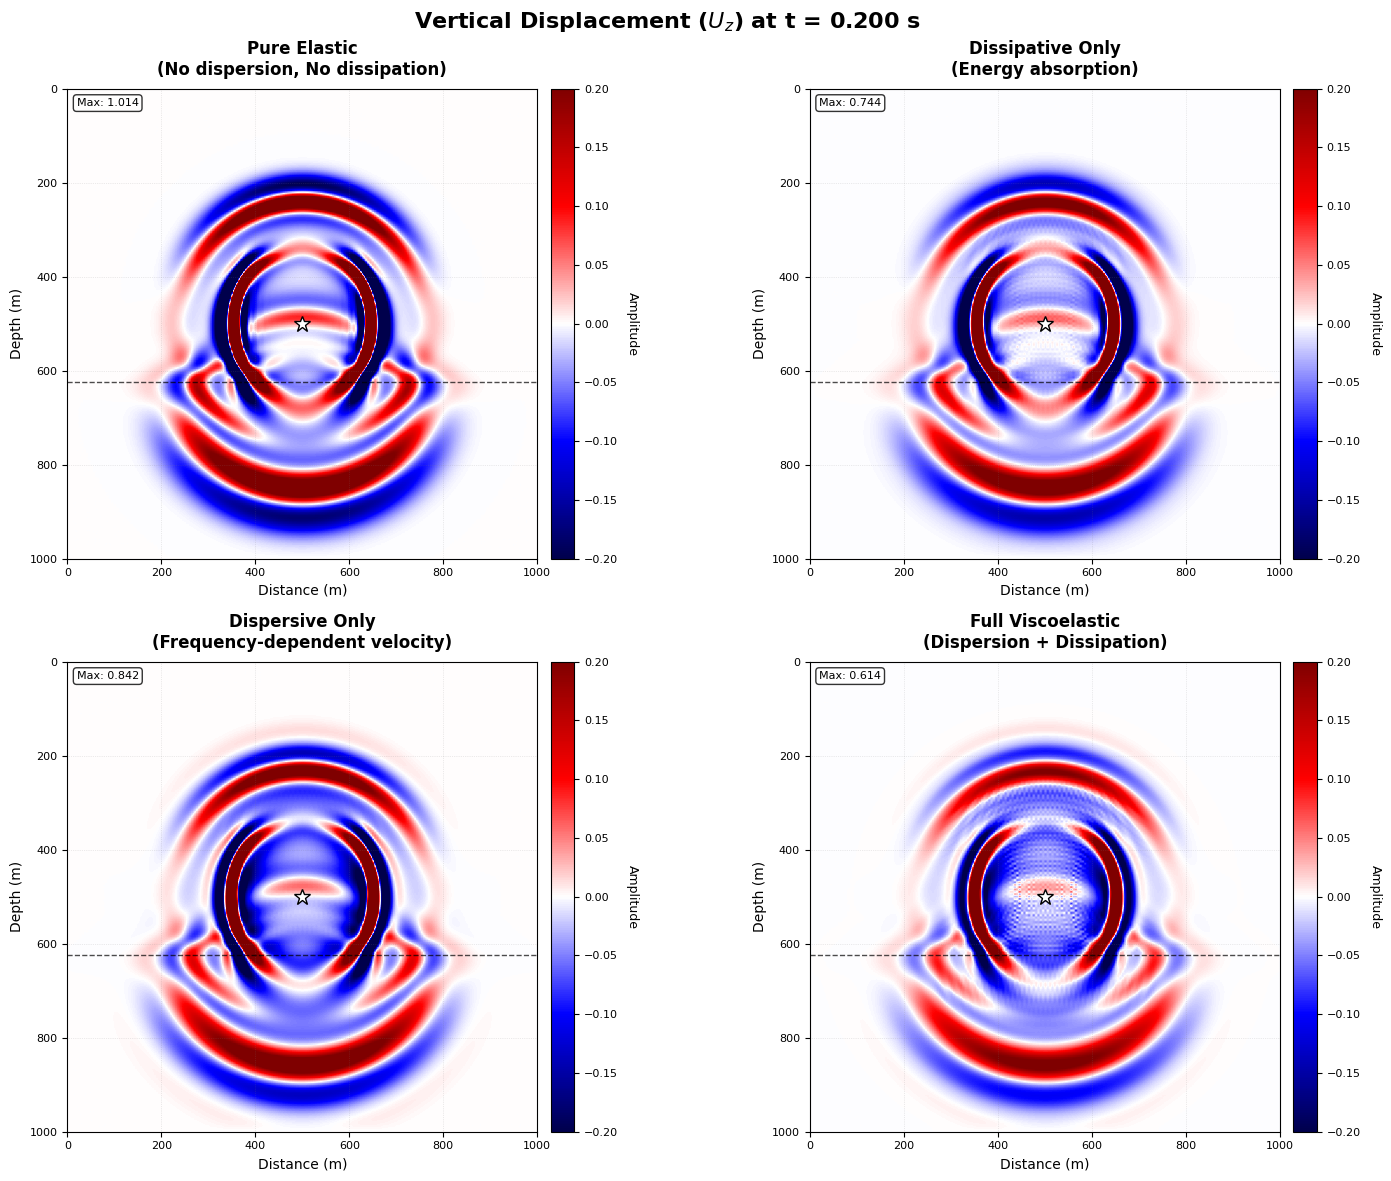

Saved: viscoelastic_ux_comparison.png


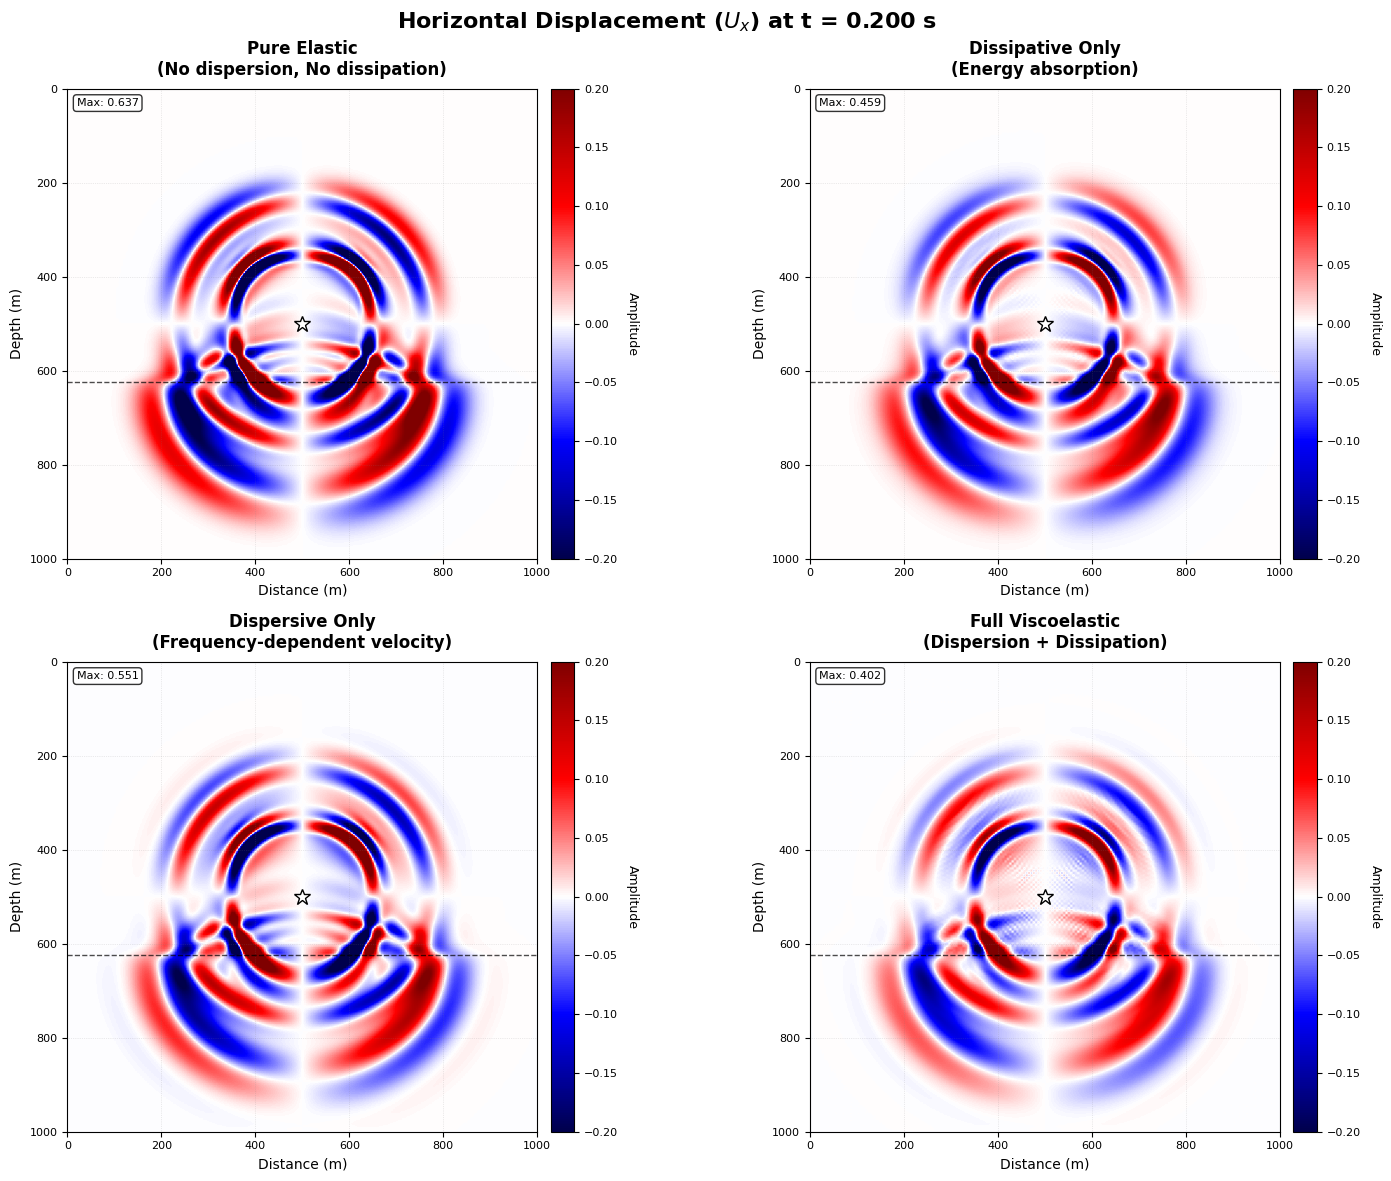

Saved: viscoelastic_total_displacement.png


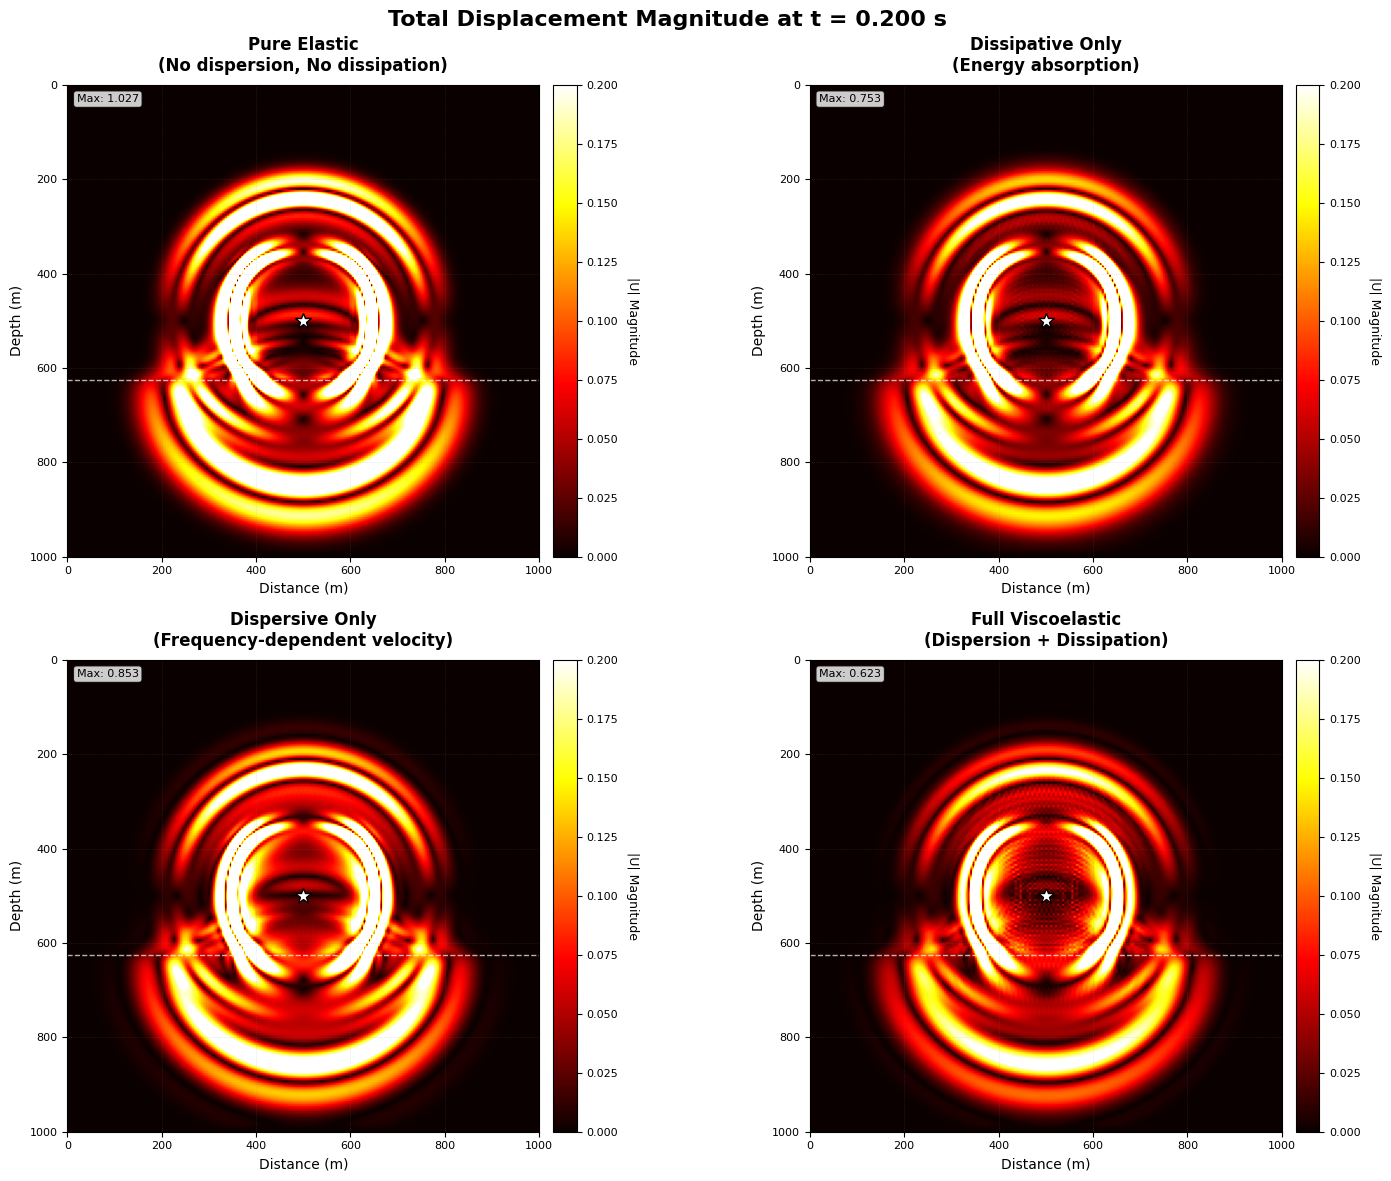

In [5]:
visualizer = WavefieldVisualizer(results, grid)
print("\nGenerating snapshot comparisons...")
visualizer.plot_snapshots(
    time_step=200,
    clip=0.2,
    interface_ratio=1.6,
    save=True )


#### Visualize - Seismograms

Saved: viscoelastic_seismograms.png


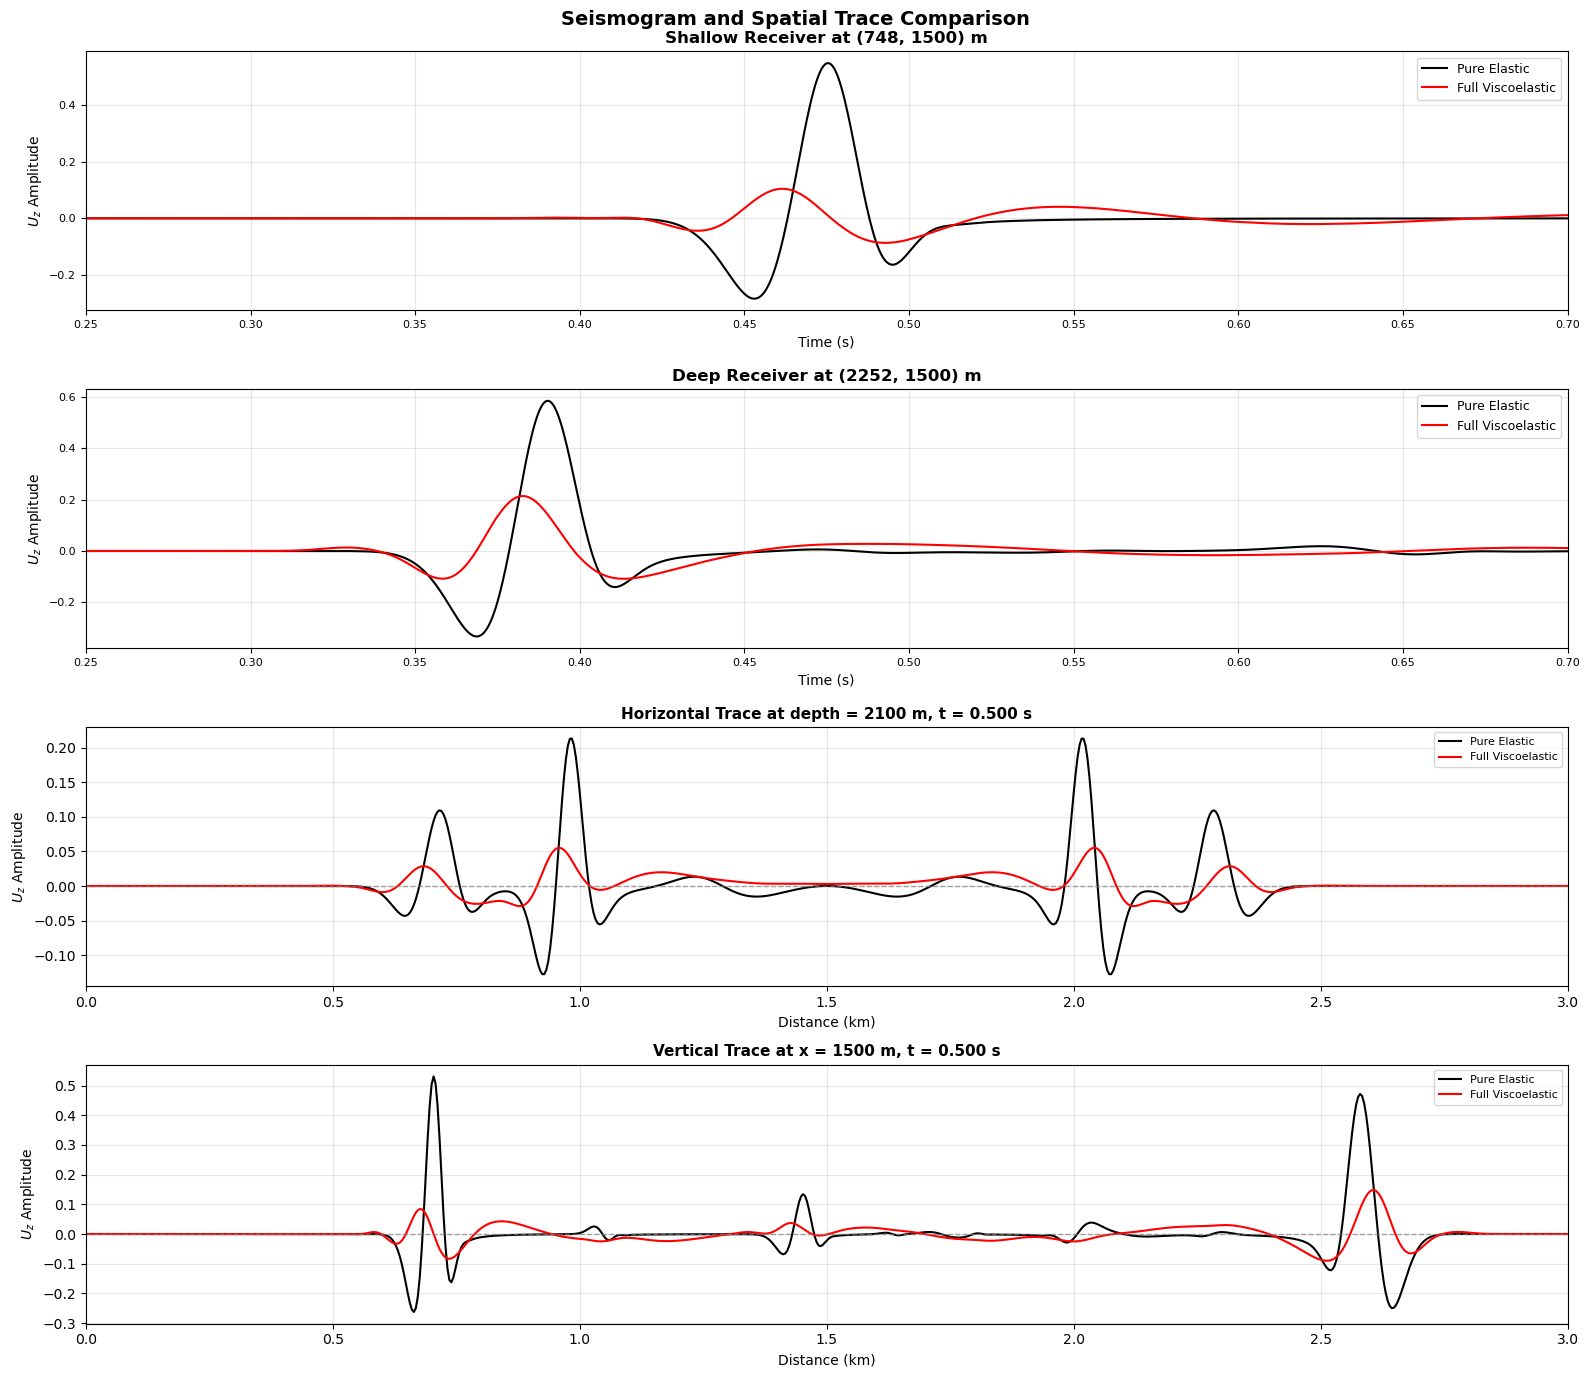

In [5]:
# Plot seismograms and traces
visualizer.plot_seismograms(
    mode_keys=['elastic', 'viscoelastic'],
    time_range=(0.25, 0.7),
    snapshot_idx=1000,
    save=True
)

# Or compare all 4 modes in seismograms
# visualizer.plot_seismograms(
#     mode_keys=['elastic', 'dissipative', 'dispersive', 'viscoelastic']
# )


#### Summary

In [2]:
# visualizer.print_summary(mode_keys=['elastic', 'dissipative', 'dispersive', 'viscoelastic'])

#### Custom Analysis

In [ ]:
# Access raw data for custom plots
elastic_uz     = results['elastic']['U_z']
viscoel_uz     = results['viscoelastic']['U_z']
dispersive_uz  = results['dispersive']['U_z']
dissipative_uz = results['dissipative']['U_z']

# Your custom plotting code here
plt.figure(figsize=(10, 6), dpi=600)
plt.plot(np.real(elastic_uz[375, 375, :]), color='black')
plt.plot(np.real(viscoel_uz[375, 375, :]), color='red')
# plt.plot(np.real(dispersive_uz[375, 375, :]))
# plt.plot(np.real(dissipative_uz[375, 375, :]))
plt.legend(['Elastic', 'Viscoelastic'])
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3, lw=1.0, ls="--", color='black')
plt.xlim(0,1000)
plt.ylim(-10,)
plt.show()

### Enhanced Visualization

In [ ]:
"""
Enhanced Visualization Module for Viscoelastic Wave Propagation
================================================================

This module provides advanced visualization tools for analyzing viscoelastic
wave propagation results, including:
- Combined quadrant comparisons
- Difference analysis
- Energy evolution tracking

"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class EnhancedVisualizer:
    """
    Advanced visualizer for viscoelastic wave propagation analysis.

    This class provides methods to create sophisticated visualizations that
    highlight the differences between elastic, dissipative, dispersive, and
    viscoelastic wave propagation.
    """

    def __init__(self, results: dict, grid_config):
        """
        Initialize the enhanced visualizer.

        Parameters:
        -----------
        results: Dictionary with keys 'elastic', 'dissipative', 'dispersive', 'viscoelastic'
                 Each contains {'U_z': array, 'U_x': array}
        grid_config: GridConfig object or dict with 'nz', 'nx', 'h', 'nt', 'dt'
        """
        self.results = results

        # Extract grid parameters
        if hasattr(grid_config, 'nz'):  # GridConfig object
            self.nz = grid_config.nz
            self.nx = grid_config.nx
            self.h  = grid_config.h
            self.nt = grid_config.nt
            self.dt = grid_config.dt
        else:  # Dictionary
            self.nz = grid_config.get('nz', 751)
            self.nx = grid_config.get('nx', 751)
            self.h  = grid_config.get('h', 4.0)
            self.nt = grid_config.get('nt', 2001)
            self.dt = grid_config.get('dt', 0.0005)

        # Validate results
        self._validate_results()

        # Physics labels
        self.physics_labels = {
            'elastic': 'Elastic (Reference)',
            'dissipative': 'Dissipative (Q-absorption)',
            'dispersive': 'Dispersive (Frequency-dependent)',
            'viscoelastic': 'Viscoelastic (Combined)'
        }

        # Colors for each physics mode
        self.colors = {
            'elastic': 'blue',
            'dissipative': 'red',
            'dispersive': 'green',
            'viscoelastic': 'purple'
        }

    def _validate_results(self):
        """Validate that all required simulation results are present."""
        required_keys = ['elastic', 'dissipative', 'dispersive', 'viscoelastic']
        for key in required_keys:
            if key not in self.results:
                raise ValueError(f"Missing simulation result: '{key}'")

    def create_combined_quadrant_plot(self, time_step: int = 1000,
                                     clip: float = 0.1,
                                     interface_ratio: float = 1.6,
                                     save: bool = True):
        """
        Create split-screen quadrant visualization.

        Each quadrant shows a different physics mode:
        ┌──────────────┬──────────────┐
        │   ELASTIC    │  DISPERSIVE  │
        ├──────────────┼──────────────┤
        │ DISSIPATIVE  │VISCOELASTIC  │
        └──────────────┴──────────────┘

        Parameters:
        -----------
        time_step: Time step to visualize
        clip: Amplitude clipping for display
        interface_ratio: Interface depth ratio
        save: Whether to save the figure
        """
        current_time = time_step * self.dt
        print(f"Creating quadrant visualization at t = {current_time:.3f} s")

        # Extract wavefields
        U_z_elastic      = self.results['elastic']['U_z']
        U_x_elastic      = self.results['elastic']['U_x']
        U_z_dissipative  = self.results['dissipative']['U_z']
        U_x_dissipative  = self.results['dissipative']['U_x']
        U_z_dispersive   = self.results['dispersive']['U_z']
        U_x_dispersive   = self.results['dispersive']['U_x']
        U_z_viscoelastic = self.results['viscoelastic']['U_z']
        U_x_viscoelastic = self.results['viscoelastic']['U_x']

        # Get grid dimensions from data
        nz_actual, nx_actual, nt = U_z_elastic.shape

        if time_step >= nt:
            raise ValueError(f"time_step ({time_step}) must be < nt ({nt})")

        # Initialize combined arrays
        combined_z = np.real(U_z_elastic[:, :, time_step]).copy()
        combined_x = np.real(U_x_elastic[:, :, time_step]).copy()

        # Define quadrant boundaries
        z_mid = nz_actual // 2
        x_mid = nx_actual // 2

        # Fill each quadrant
        # Top-right: Dispersive
        combined_z[:z_mid, x_mid:] = np.real(U_z_dispersive[:z_mid, x_mid:, time_step])
        combined_x[:z_mid, x_mid:] = np.real(U_x_dispersive[:z_mid, x_mid:, time_step])

        # Bottom-left: Dissipative
        combined_z[z_mid:, :x_mid] = np.real(U_z_dissipative[z_mid:, :x_mid, time_step])
        combined_x[z_mid:, :x_mid] = np.real(U_x_dissipative[z_mid:, :x_mid, time_step])

        # Bottom-right: Viscoelastic
        combined_z[z_mid:, x_mid:] = np.real(U_z_viscoelastic[z_mid:, x_mid:, time_step])
        combined_x[z_mid:, x_mid:] = np.real(U_x_viscoelastic[z_mid:, x_mid:, time_step])

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f'Viscoelastic Effects Comparison at t = {current_time:.3f} s',
                    fontsize=16, fontweight='bold')

        # Coordinate arrays
        z_coords = np.arange(nz_actual) * self.h
        x_coords = np.arange(nx_actual) * self.h

        # Plot vertical displacement
        im1 = ax1.imshow(combined_z, vmin=-clip, vmax=clip, cmap='seismic',
                        aspect='equal', extent=[0, x_coords[-1], z_coords[-1], 0],
                        origin='upper')
        ax1.set_title('Vertical Displacement ($U_z$)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Distance (m)', fontsize=12)
        ax1.set_ylabel('Depth (m)', fontsize=12)

        # Add quadrant lines
        ax1.axhline(y=z_coords[z_mid], color='black', linestyle='--', linewidth=1, alpha=0.7)
        ax1.axvline(x=x_coords[x_mid], color='black', linestyle='--', linewidth=1, alpha=0.7)

        # Add labels
        self._add_quadrant_labels(ax1, z_coords, x_coords)

        # Colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)
        cbar1.set_label('Amplitude', fontsize=11, rotation=270, labelpad=15)

        # Plot horizontal displacement
        im2 = ax2.imshow(combined_x, vmin=-clip, vmax=clip, cmap='seismic',
                        aspect='equal', extent=[0, x_coords[-1], z_coords[-1], 0],
                        origin='upper')
        ax2.set_title('Horizontal Displacement ($U_x$)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Distance (m)', fontsize=12)
        ax2.set_ylabel('Depth (m)', fontsize=12)

        # Add quadrant lines
        ax2.axhline(y=z_coords[z_mid], color='black', linestyle='--', linewidth=1, alpha=0.7)
        ax2.axvline(x=x_coords[x_mid], color='black', linestyle='--', linewidth=1, alpha=0.7)

        # Add labels
        self._add_quadrant_labels(ax2, z_coords, x_coords)

        # Colorbar
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02)
        cbar2.set_label('Amplitude', fontsize=11, rotation=270, labelpad=15)

        ######################################
        # Mark source location on both plots #
        ######################################
        src_z = (self.nz // 2) * self.h
        src_x = (self.nx // 2) * self.h

        # Source marker styling
        source_marker_style = dict(markersize=12, markerfacecolor='yellow',
                                  markeredgecolor='black', markeredgewidth=2,
                                  marker='*', alpha=0.9)

        ax1.plot(src_x, src_z, **source_marker_style, label='Source')
        ax2.plot(src_x, src_z, **source_marker_style, label='Source')

        # Add grids
        for ax in [ax1, ax2]:
            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, color='gray')
            ax.tick_params(labelsize=10)

        plt.tight_layout()

        if save:
            filename = f"combined_quadrant_t{time_step:04d}.png"
            plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white')
            print(f"Saved: {filename}")

        plt.show()

        return combined_z, combined_x

    def _add_quadrant_labels(self, ax, z_coords, x_coords):
        """Add labels to each quadrant."""
        label_style = dict(boxstyle='round,pad=0.5', facecolor='white',
                          alpha=0.9, edgecolor='black', linewidth=1.5)

        z_q  = z_coords[-1] / 4
        z_3q = 3 * z_coords[-1] / 4
        x_q  = x_coords[-1] / 4
        x_3q = 3 * x_coords[-1] / 4

        ax.text(x_q, z_q, 'ELASTIC\n(Reference)', ha='center', va='center',
               fontsize=11, fontweight='bold', bbox=label_style)
        ax.text(x_3q, z_q, 'DISPERSIVE\n(Freq. Dependent)', ha='center', va='center',
               fontsize=11, fontweight='bold', bbox=label_style)
        ax.text(x_q, z_3q, 'DISSIPATIVE\n(Energy Loss)', ha='center', va='center',
               fontsize=11, fontweight='bold', bbox=label_style)
        ax.text(x_3q, z_3q, 'VISCOELASTIC\n(Combined)', ha='center', va='center',
               fontsize=11, fontweight='bold', bbox=label_style)

    def create_difference_plots(self, time_step: int = 1000,
                               clip: float = 0.05,
                               interface_ratio: float = 1.6,
                               save: bool = True):
        """
        Create difference plots showing isolated effects.

        Computes: Effect - Elastic (reference)

        Parameters:
        -----------
        time_step: Time step to analyze
        clip: Amplitude clipping for differences
        interface_ratio: Interface depth ratio
        save: Whether to save the figure
        """
        current_time = time_step * self.dt
        print(f"Computing difference plots at t = {current_time:.3f} s")

        # Extract elastic reference
        U_z_elastic = self.results['elastic']['U_z']
        U_x_elastic = self.results['elastic']['U_x']

        # Compute differences
        differences = {}
        for mode in ['dissipative', 'dispersive', 'viscoelastic']:
            U_z = self.results[mode]['U_z']
            U_x = self.results[mode]['U_x']

            diff_z = np.real(U_z[:, :, time_step] - U_z_elastic[:, :, time_step])
            diff_x = np.real(U_x[:, :, time_step] - U_x_elastic[:, :, time_step])

            differences[mode] = {'U_z': diff_z, 'U_x': diff_x}

        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Viscoelastic Effects: Differences from Elastic Reference\n'
                    f't = {current_time:.3f} s (Step {time_step})',
                    fontsize=16, fontweight='bold')

        # Coordinate arrays
        nz, nx, _ = U_z_elastic.shape
        z_coords  = np.arange(nz) * self.h
        x_coords  = np.arange(nx) * self.h
        interface_depth = int(nz // interface_ratio) * self.h

        # Source position
        src_z = (self.nz // 2) * self.h
        src_x = (self.nx // 2) * self.h

        effect_names = ['Dissipation', 'Dispersion', 'Combined']
        modes = ['dissipative', 'dispersive', 'viscoelastic']

        # Physical interpretations for each effect
        interpretations = [
            'Energy absorption reduces amplitude',
            'Frequency dispersion causes pulse spreading',
            'Both effects combined'
        ]

        # Plot U_z differences
        for i, (mode, name, interp) in enumerate(zip(modes, effect_names, interpretations)):
            ax = axes[0, i]
            diff_z = differences[mode]['U_z']

            im = ax.imshow(diff_z, vmin=-clip, vmax=clip, cmap='RdBu_r',
                          aspect='equal', extent=[0, x_coords[-1], z_coords[-1], 0],
                          origin='upper')

            ax.set_title(f'{name} Effect\n$\\Delta U_z$', fontsize=12, fontweight='bold')
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Depth (m)', fontsize=11)

            # Interface line
            ax.axhline(y=interface_depth, color='black', linestyle='--',
                      alpha=0.7, linewidth=1.)

            # Source marker styling
            source_marker_style = dict(markersize=12, markerfacecolor='yellow',
                                      markeredgecolor='black', markeredgewidth=2,
                                      marker='*', alpha=0.9)

            ax.plot(src_x, src_z, **source_marker_style, label='Source')
            ax.plot(src_x, src_z, **source_marker_style, label='Source')

            # Colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
            cbar.set_label('$\\Delta$ Amplitude', fontsize=10, rotation=270, labelpad=15)

            # Statistics as text annotation
            max_diff = np.max(np.abs(diff_z))
            rms_diff = np.sqrt(np.mean(diff_z**2))
            ax.text(0.02, 0.98, f'Max: {max_diff:.4f}\nRMS: {rms_diff:.4f}',
                   transform=ax.transAxes, fontsize=9, va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Add interpretation text
            ax.text(0.98, 0.02, interp, transform=ax.transAxes,
                   fontsize=9, ha='right', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax.tick_params(labelsize=9)

        # Plot U_x differences
        for i, (mode, name, interp) in enumerate(zip(modes, effect_names, interpretations)):
            ax = axes[1, i]
            diff_x = differences[mode]['U_x']

            im = ax.imshow(diff_x, vmin=-clip, vmax=clip, cmap='RdBu_r',
                          aspect='equal', extent=[0, x_coords[-1], z_coords[-1], 0],
                          origin='upper')

            ax.set_title(f'{name} Effect\n$\\Delta U_x$', fontsize=12, fontweight='bold')
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Depth (m)', fontsize=11)

            # Interface line
            ax.axhline(y=interface_depth, color='black', linestyle='--',
                      alpha=0.7, linewidth=1.)

            # Source marker styling
            source_marker_style = dict(markersize=12, markerfacecolor='yellow',
                                      markeredgecolor='black', markeredgewidth=2,
                                      marker='*', alpha=0.9)

            ax.plot(src_x, src_z, **source_marker_style, label='Source')
            ax.plot(src_x, src_z, **source_marker_style, label='Source')

            # Colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
            cbar.set_label('$\\Delta$ Amplitude', fontsize=10, rotation=270, labelpad=15)

            # Statistics
            max_diff = np.max(np.abs(diff_x))
            rms_diff = np.sqrt(np.mean(diff_x**2))
            ax.text(0.02, 0.98, f'Max: {max_diff:.4f}\nRMS: {rms_diff:.4f}',
                   transform=ax.transAxes, fontsize=9, va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Add interpretation text
            ax.text(0.98, 0.02, interp, transform=ax.transAxes,
                   fontsize=9, ha='right', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax.tick_params(labelsize=9)

        plt.tight_layout()

        if save:
            filename = f"difference_plots_t{time_step:04d}.png"
            plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white')
            print(f"Saved: {filename}")

        plt.show()

        # Print quantitative analysis
        self._print_difference_analysis(differences)

        return differences

    def _print_difference_analysis(self, differences):
        """Print quantitative analysis of differences."""
        print(f"\nQuantitative Analysis:")
        print(f"{'Effect':<15} {'Component':<10} {'Max |Δ|':>12} {'RMS':>12} {'Energy Change (%)':>18}")
        print("-" * 70)

        for mode, data in differences.items():
            for comp, diff_array in data.items():
                max_diff = np.max(np.abs(diff_array))
                rms_diff = np.sqrt(np.mean(diff_array**2))
                energy_change = np.sum(diff_array**2) / diff_array.size * 100
                print(f"{mode:<15} {comp:<10} {max_diff:>12.6f} {rms_diff:>12.6f} {energy_change:>18.4f} %")

    def create_energy_evolution(self, time_range: tuple = None, save: bool = True):
        """
        Analyze energy evolution over time.

        Parameters:
        -----------
        time_range: (start, end) time steps. If None, use full range
        save: Whether to save the figure
        """
        print("Analyzing energy evolution...")

        # Get actual grid dimensions
        nz, nx, nt = self.results['elastic']['U_z'].shape

        if time_range is None:
            time_range = (0, nt)

        start, end = time_range
        time_steps = np.arange(start, min(end, nt))
        time_axis = time_steps * self.dt

        # Compute energy for each mode
        # Energy ∝ ∫(|U_z|² + |U_x|²) dV
        energy_data = {}

        for mode in ['elastic', 'dissipative', 'dispersive', 'viscoelastic']:
            U_z = self.results[mode]['U_z']
            U_x = self.results[mode]['U_x']

            energy_series = []
            for it in time_steps:
                energy_z = np.sum(np.abs(U_z[:, :, it])**2)
                energy_x = np.sum(np.abs(U_x[:, :, it])**2)
                total_energy = energy_z + energy_x
                energy_series.append(total_energy)

            energy_data[mode] = np.array(energy_series)

        # Create plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        fig.suptitle('Energy Evolution: Viscoelastic Effects',
                    fontsize=16, fontweight='bold')

        # Plot 1: Absolute energy
        for mode, energy in energy_data.items():
            ax1.plot(time_axis, energy, color=self.colors[mode],
                    linewidth=2, label=self.physics_labels[mode])

        ax1.set_title('Total Wave Energy', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time (s)', fontsize=12)
        ax1.set_ylabel('Energy (arbitrary units)', fontsize=12)
        ax1.legend(fontsize=10, loc='best')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Normalized energy
        initial_energy = energy_data['elastic'][0] if len(energy_data['elastic']) > 0 else 1.0

        for mode, energy in energy_data.items():
            normalized = energy / initial_energy
            ax2.plot(time_axis, normalized, color=self.colors[mode],
                    linewidth=2, label=self.physics_labels[mode])

        ax2.set_title('Normalized Energy (Relative to Initial)',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time (s)', fontsize=12)
        ax2.set_ylabel('Normalized Energy', fontsize=12)
        ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, lw=1.0)
        ax2.legend(fontsize=10, loc='best')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save:
            plt.savefig("energy_evolution.png", dpi=600, bbox_inches='tight', facecolor='white')
            print("Saved: energy_evolution.png")

        plt.show()

        return energy_data

    def run_all(self, time_step: int = 1000, clip: float = 0.1,
                diff_clip: float = 0.05, energy_range: tuple = None):
        """
        Run all enhanced visualizations.

        Parameters:
        -----------
        time_step: Time step for snapshot visualizations
        clip: Amplitude clipping for main plots
        diff_clip: Amplitude clipping for difference plots
        energy_range: Time range for energy analysis
        """
        print("=" * 80)
        print("ENHANCED VISCOELASTIC VISUALIZATION SUITE")
        print("=" * 80)

        try:
            # 1. Quadrant visualization
            print("\n1. Creating combined quadrant visualization...")
            combined = self.create_combined_quadrant_plot(time_step, clip)

            # 2. Difference analysis
            print("\n2. Creating difference analysis...")
            differences = self.create_difference_plots(time_step, diff_clip)

            # 3. Energy evolution
            print("\n3. Creating energy evolution analysis...")
            energy = self.create_energy_evolution(energy_range)

            print("\n" + "=" * 80)
            print("✓ ENHANCED VISUALIZATION COMPLETED SUCCESSFULLY")
            print("=" * 80)

            return {
                'combined': combined,
                'differences': differences,
                'energy': energy
            }

        except Exception as e:
            print(f"Error in visualization: {e}")
            raise


# ==============================================================================
# READY TO USE!
# ==============================================================================

print("=" * 80)
print("Enhanced Viscoelastic Visualization Module - Ready!")
print("=" * 80)
print("\nClass loaded: EnhancedVisualizer")
print("\nQuick Start:")
print("  1. Initialize: viz = EnhancedVisualizer(results, grid)")
print("  2. Run all: viz.run_all(time_step=1000)")
print("\nOr run individual methods:")
print("  • viz.create_combined_quadrant_plot()")
print("  • viz.create_difference_plots()")
print("  • viz.create_energy_evolution()")
print("=" * 80)


Saved: difference_plots_t1000.png


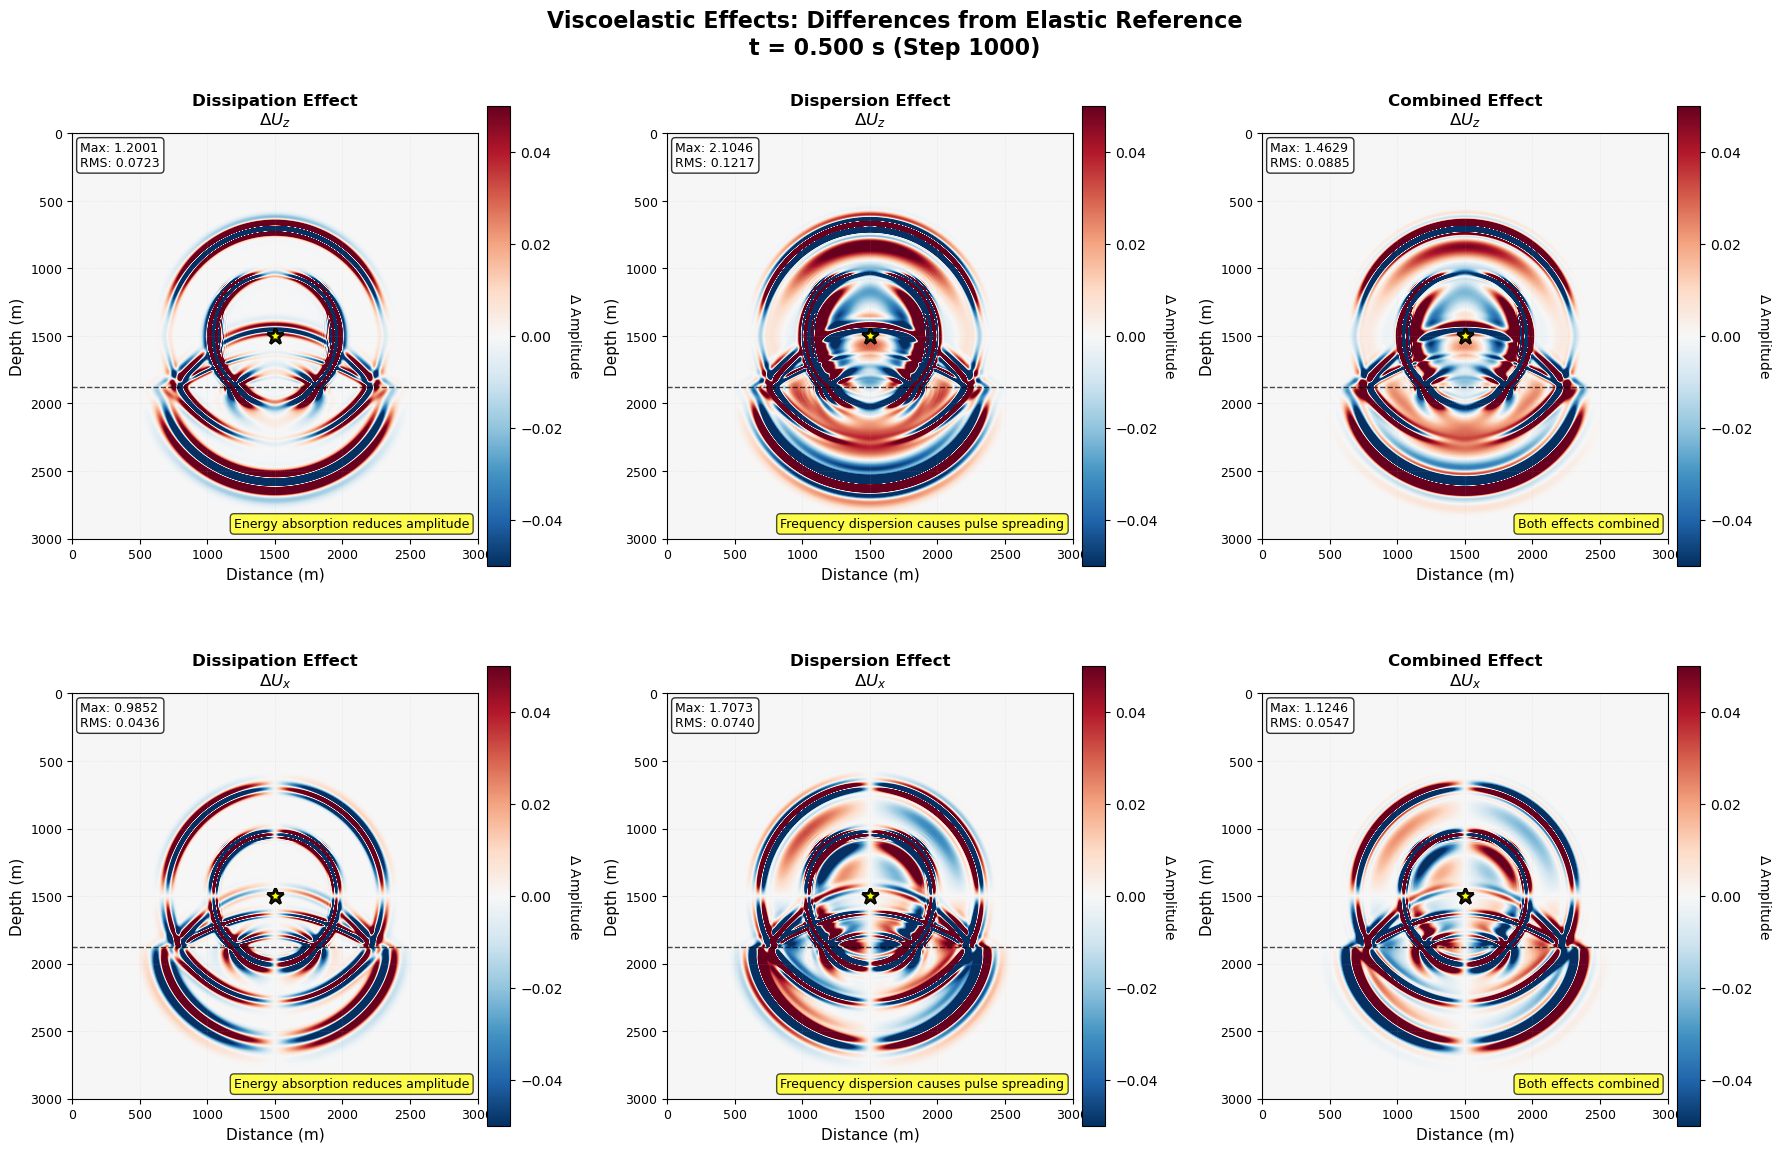


Quantitative Analysis:
Effect          Component       Max |Δ|          RMS  Energy Change (%)
----------------------------------------------------------------------
dissipative     U_z            1.200094     0.072265             0.5222 %
dissipative     U_x            0.985227     0.043625             0.1903 %
dispersive      U_z            2.104588     0.121672             1.4804 %
dispersive      U_x            1.707272     0.074004             0.5477 %
viscoelastic    U_z            1.462892     0.088540             0.7839 %
viscoelastic    U_x            1.124595     0.054677             0.2990 %

3. Creating energy evolution analysis...
Analyzing energy evolution...
Saved: energy_evolution.png


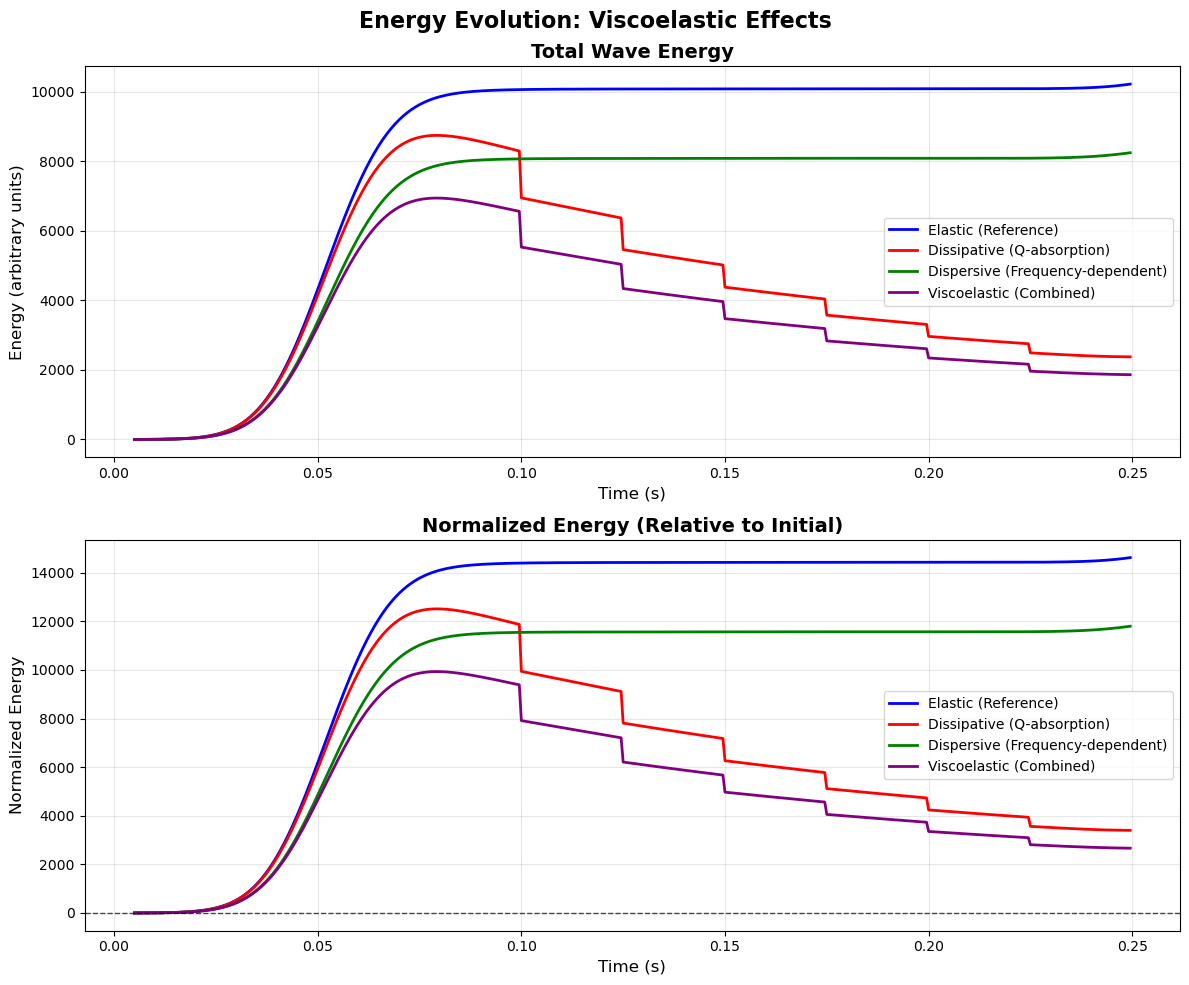


✓ ENHANCED VISUALIZATION COMPLETED SUCCESSFULLY


In [9]:
# Initialize the enhanced visualizer
viz = EnhancedVisualizer(results, grid)

# Run all enhanced visualizations at once
analysis_results = viz.run_all(
    time_step=1000,
    clip=0.1,
    diff_clip=0.05,
    energy_range=(10, 500)
)

# Just the quadrant plot
# combined = viz.create_combined_quadrant_plot(time_step=1000, clip=0.1)

# # Just the difference analysis
# differences = viz.create_difference_plots(time_step=1000, clip=0.05)

# # Just the energy evolution
# energy = viz.create_energy_evolution(time_range=(0, 1000))

# # Access specific results
# print("Energy dissipation:", analysis['energy']['dissipative'][-1])
